<a href="https://colab.research.google.com/github/yashika-ishi/CSI_Assignments_2025/blob/main/Project_House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Celebal Technologies**
*Celebel Summer Internship (CSI)*
<br>
Assignment : House Price Prediction
<br>
Description:
<br>
1. Predicting the selling price of houses based on various features such as area, number of bedrooms, location, etc.
    <br>Resources :<br>
    https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

 DATASET:  (https://github.com/yashika-ishi/CSI_Assignments_2025/tree/main/house-prices-advanced-regression-techniques)

***By: Yashika***

# **Step 1: Importing Libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **Step 2: Load the Dataset**

In [4]:
# Load the dataset
try:
    df = pd.read_csv('/content/drive/MyDrive/CSI DATASETS/house-prices-advanced-regression-techniques/train.csv')
    print("Dataset loaded successfully using direct filename access.")
except FileNotFoundError:
    print("Error: train.csv not found using direct filename access. This suggests an environment issue with file paths for uploaded files.")
    print("Attempting to load via content_fetcher as a fallback, though previous attempts had issues.")
    try:
        import io
        train_csv_content_fetch_id = "uploaded:train.csv"
        fetched_content_raw = content_fetcher.fetch(
            query="train.csv data",
            source_references=[content_fetcher.SourceReference(id=train_csv_content_fetch_id, type="text/csv")]
        )
        csv_content = str(fetched_content_raw) # Attempt to convert FutureResponse to string
        df = pd.read_csv(io.StringIO(csv_content))
        print("Dataset loaded successfully using content_fetcher (after string conversion).")
    except Exception as e:
        print(f"Error loading dataset even with content_fetcher: {e}")
        print("Could not load the dataset. Please ensure the file is correctly uploaded and accessible.")
        raise # Re-raise to stop execution if file cannot be loaded

Dataset loaded successfully using direct filename access.


# **Step 3: Display basic information**

In [5]:
# Display basic information
print("\nDataset Info:")
df.info()

print("\nMissing Values before preprocessing:")
print(df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False))


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64 

# **Step 4: Data Preprocessing**

# **Step 4.1: Handling Missing Values**

In [6]:
# Columns with many NaNs that indicate 'None' or 'No'
none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
             'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
             'MasVnrType']
for col in none_cols:
    if col in df.columns:
        df[col] = df[col].fillna('None')

# Numerical columns that can be filled with 0 (e.g., no garage means 0 cars, 0 area)
zero_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
             'BsmtUnfSF', 'TotalBsmtSF', 'MasVnrArea']
for col in zero_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# LotFrontage: Impute with median of the neighborhood
if 'LotFrontage' in df.columns:
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# General numerical imputation (for any remaining numerical NaNs)
for col in df.select_dtypes(include=np.number).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

# General categorical imputation (for any remaining categorical NaNs)
for col in df.select_dtypes(include='object').columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])

print("\nMissing Values after preprocessing:")
print(df.isnull().sum()[df.isnull().sum() > 0]) # Should be empty or very few


Missing Values after preprocessing:
Series([], dtype: int64)


# **Step 5. Feature Engineering**

In [7]:
# Total Square Footage
df['TotalSF'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF']

# Total Bathrooms
df['TotalBath'] = df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']) + \
                  df['FullBath'] + (0.5 * df['HalfBath'])

# Age of House
df['AgeOfHouse'] = df['YrSold'] - df['YearBuilt']
df['RemodelAge'] = df['YrSold'] - df['YearRemodAdd']

# Check for negative ages (if any, means data entry error or remodel before built)
df.loc[df['AgeOfHouse'] < 0, 'AgeOfHouse'] = 0
df.loc[df['RemodelAge'] < 0, 'RemodelAge'] = 0

# Has Pool (binary feature)
df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

# Has Garage (binary feature)
df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

# Has Basement (binary feature)
df['HasBsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

# Has Fireplace (binary feature)
df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

print("\nNew Features Created:")
print(df[['TotalSF', 'TotalBath', 'AgeOfHouse', 'RemodelAge', 'HasPool', 'HasGarage', 'HasBsmt', 'HasFireplace']].head())


New Features Created:
   TotalSF  TotalBath  AgeOfHouse  RemodelAge  HasPool  HasGarage  HasBsmt  \
0     2566        3.5           5           5        0          1        1   
1     2524        2.5          31          31        0          1        1   
2     2706        3.5           7           6        0          1        1   
3     2473        2.0          91          36        0          1        1   
4     3343        3.5           8           8        0          1        1   

   HasFireplace  
0             0  
1             1  
2             1  
3             1  
4             1  


# **Generate Graphs for Each Feature**


Generating graphs for each feature...


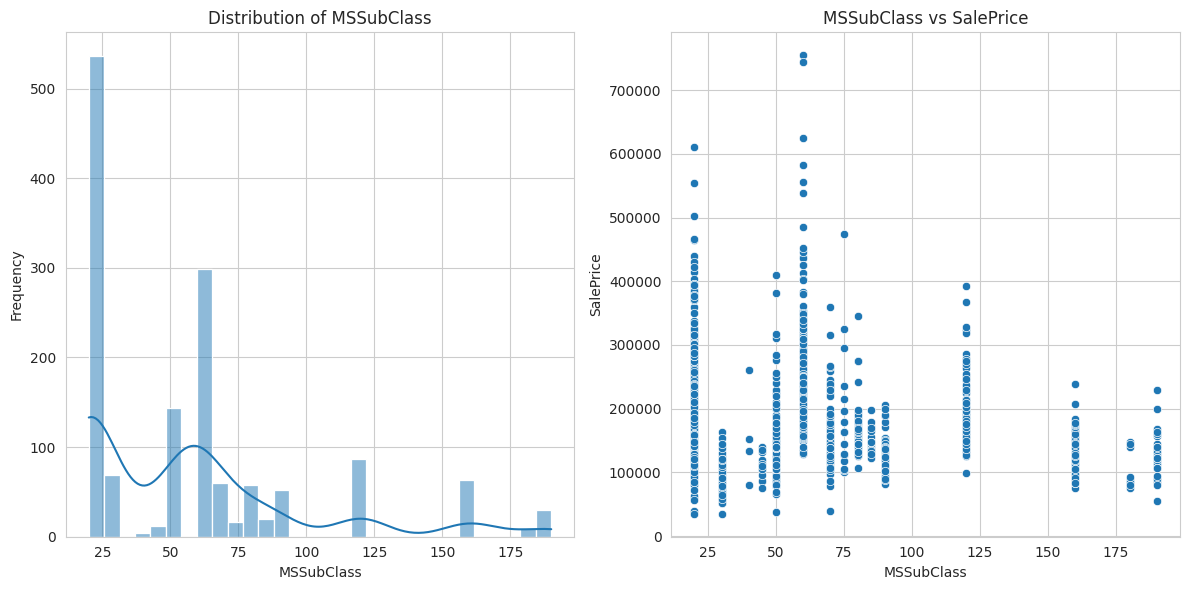

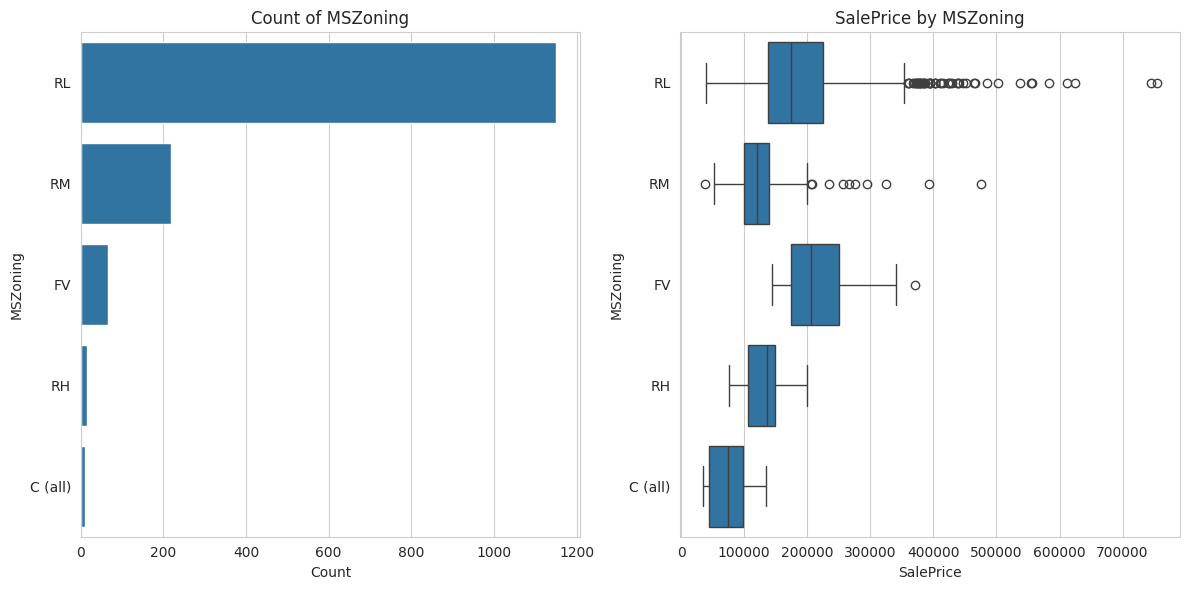

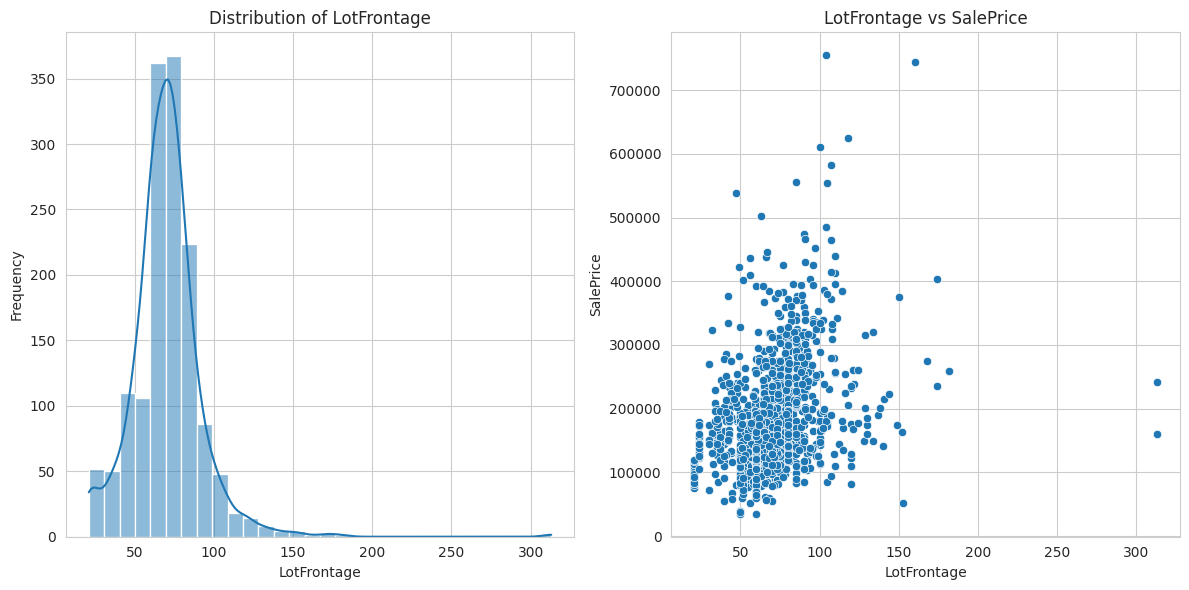

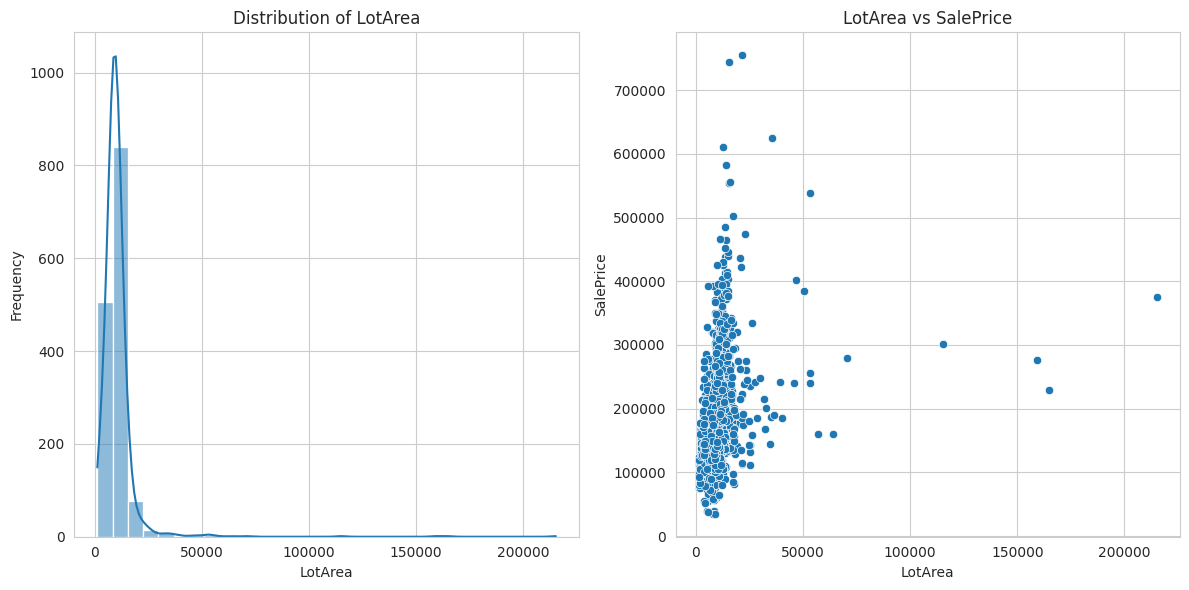

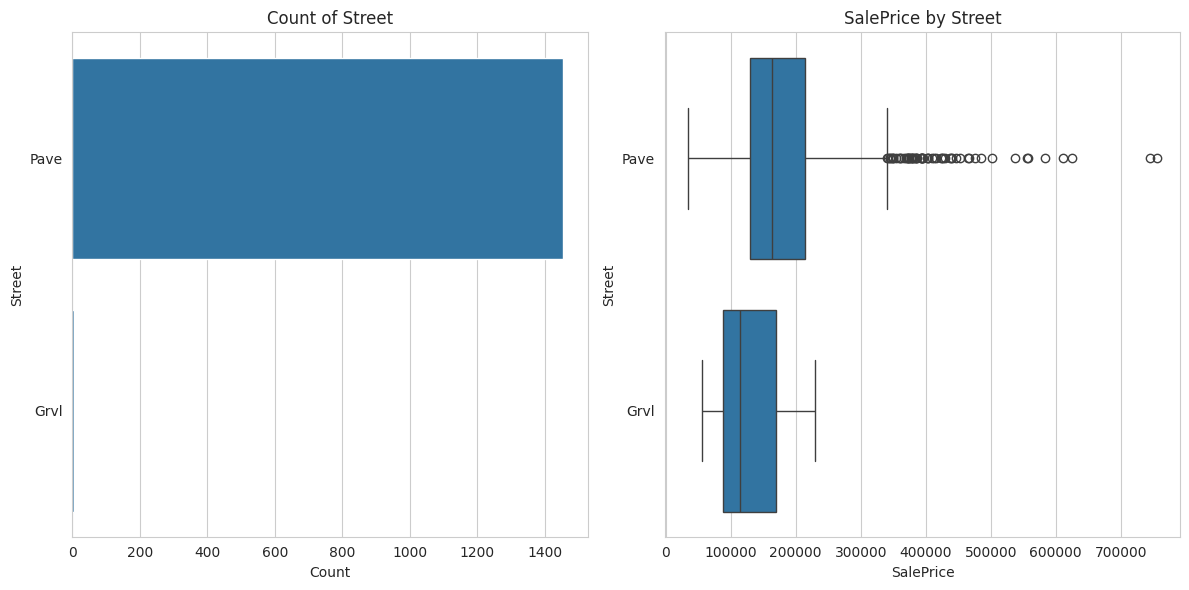

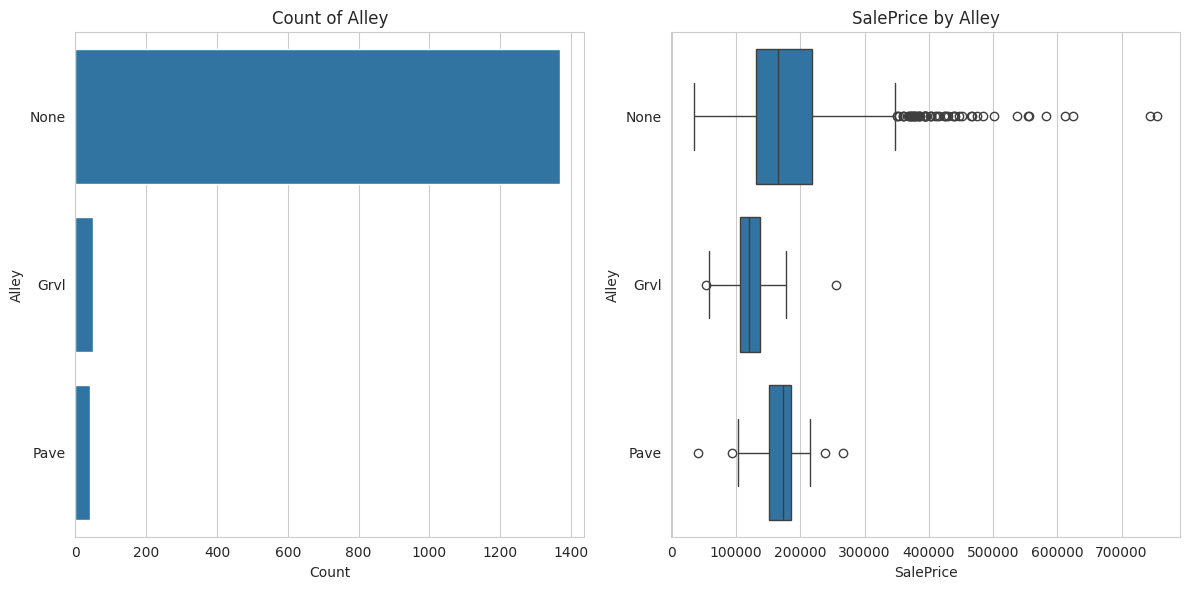

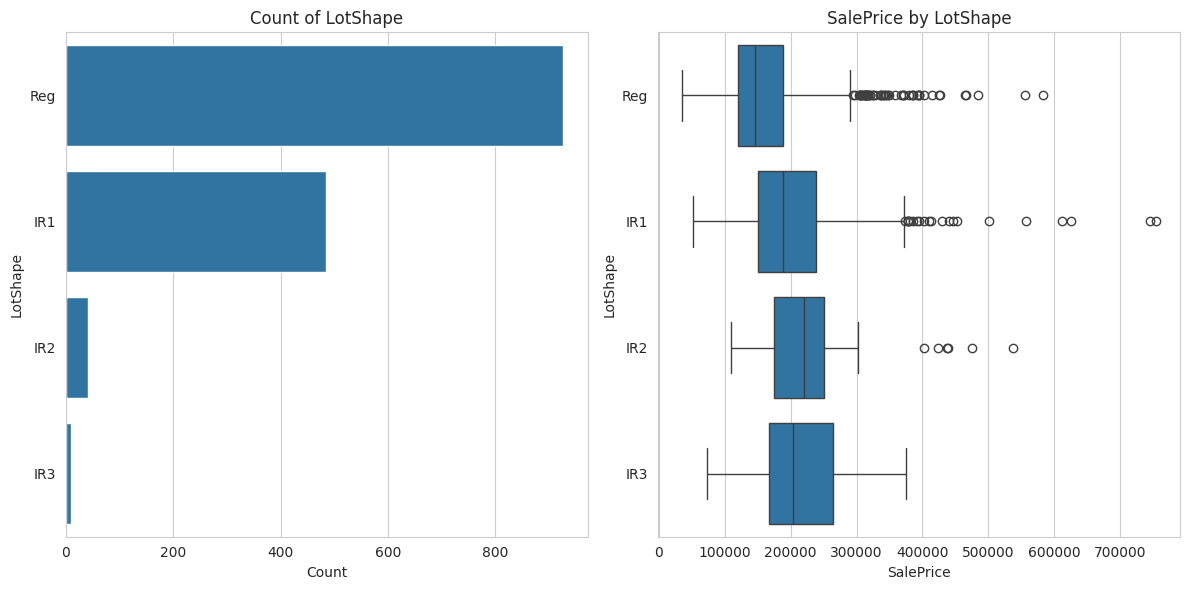

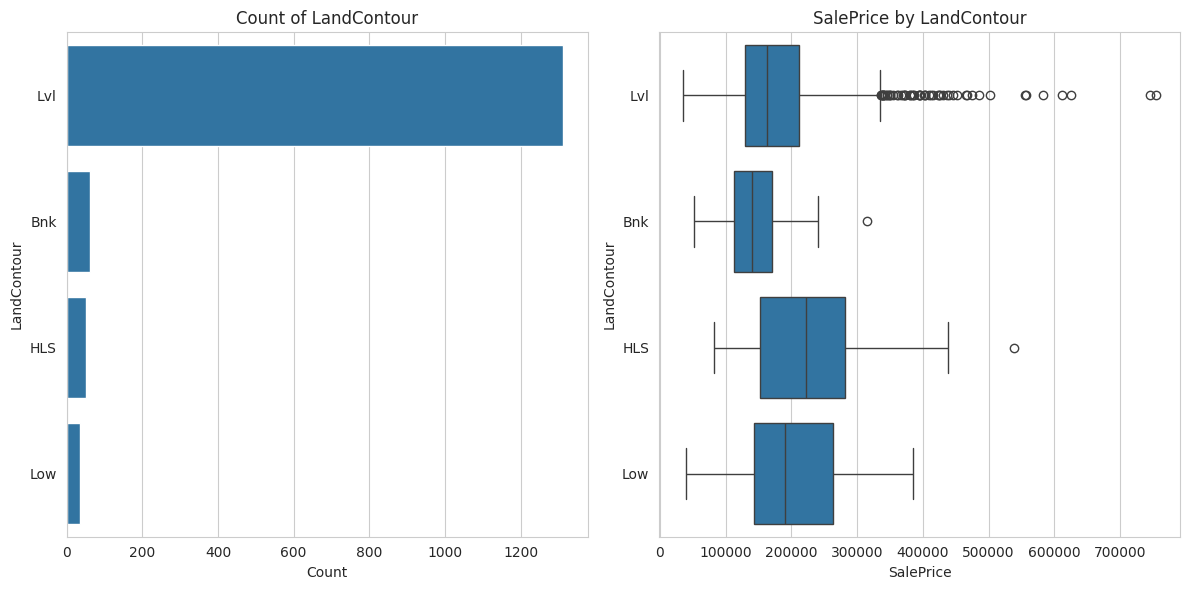

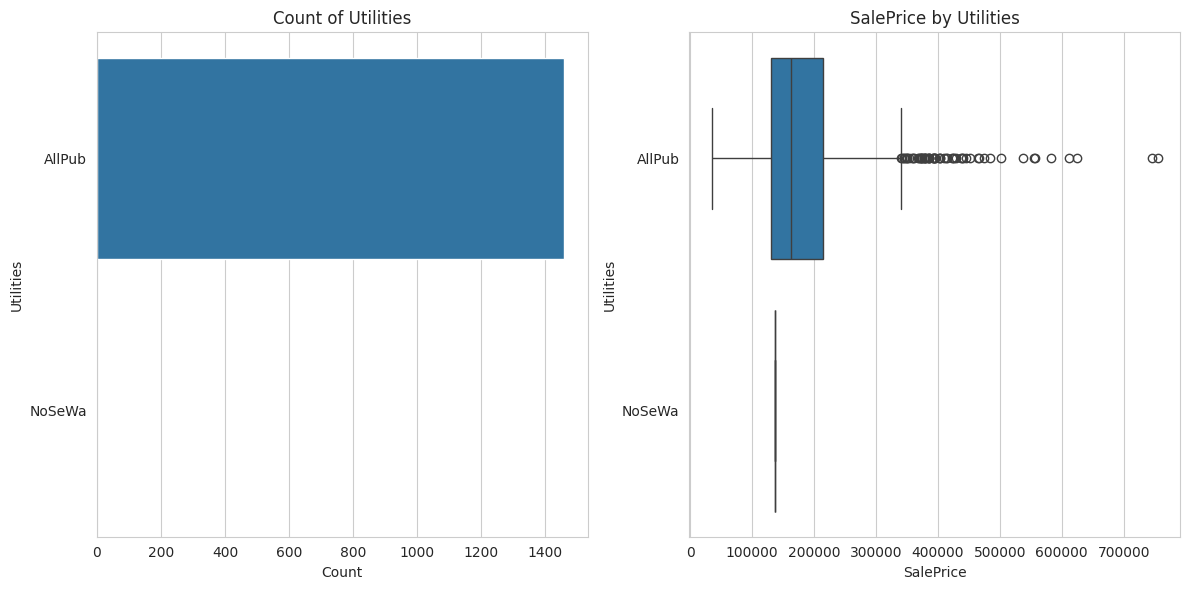

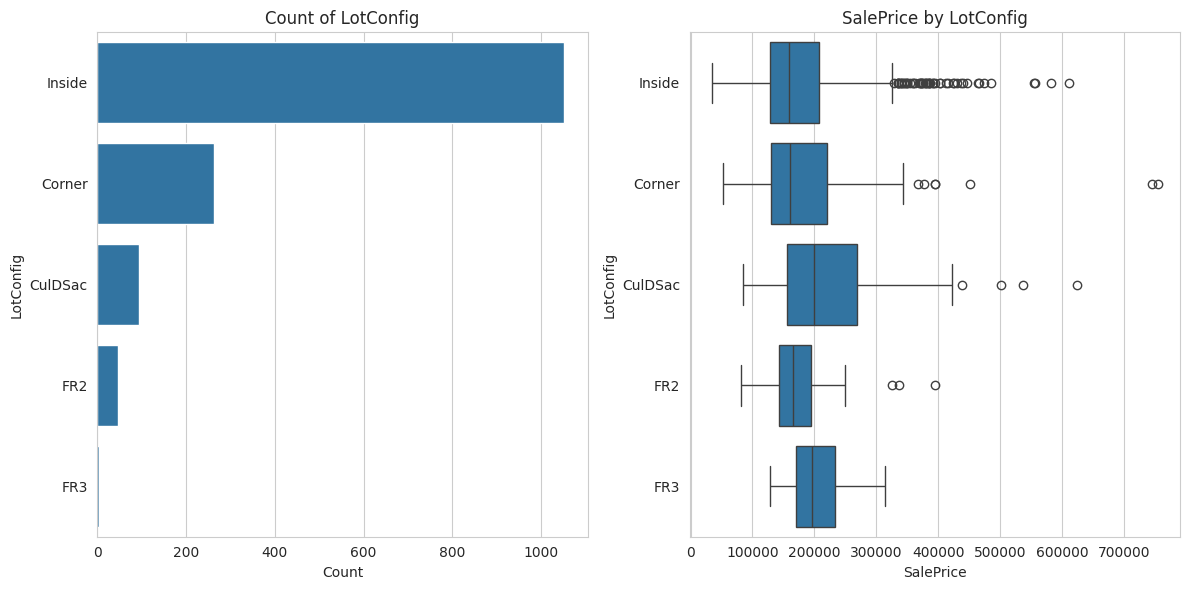

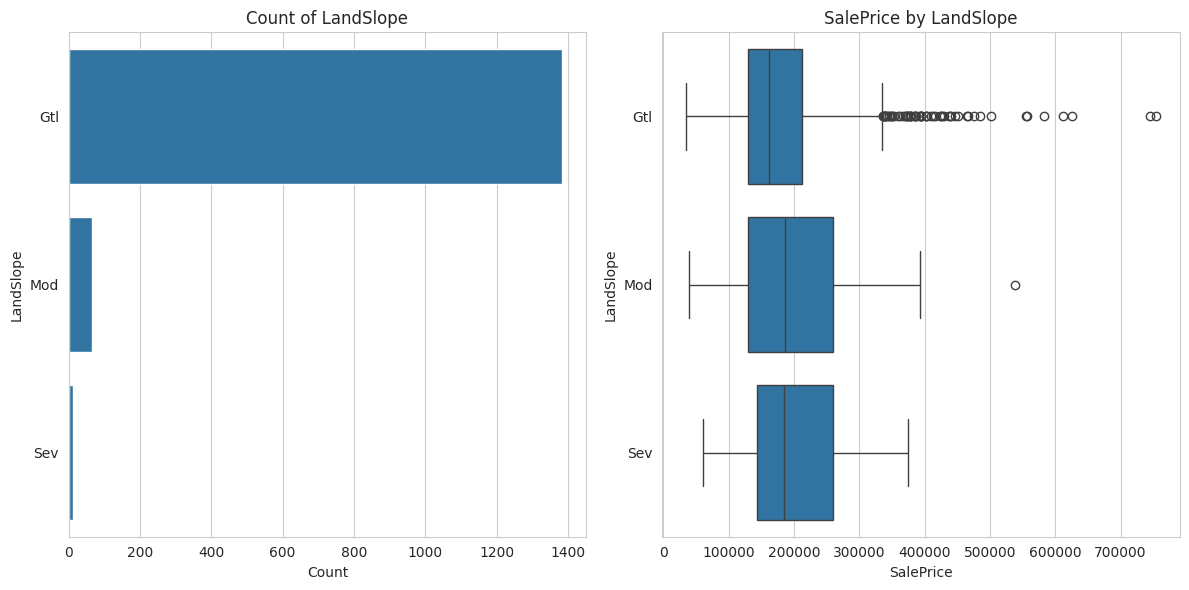

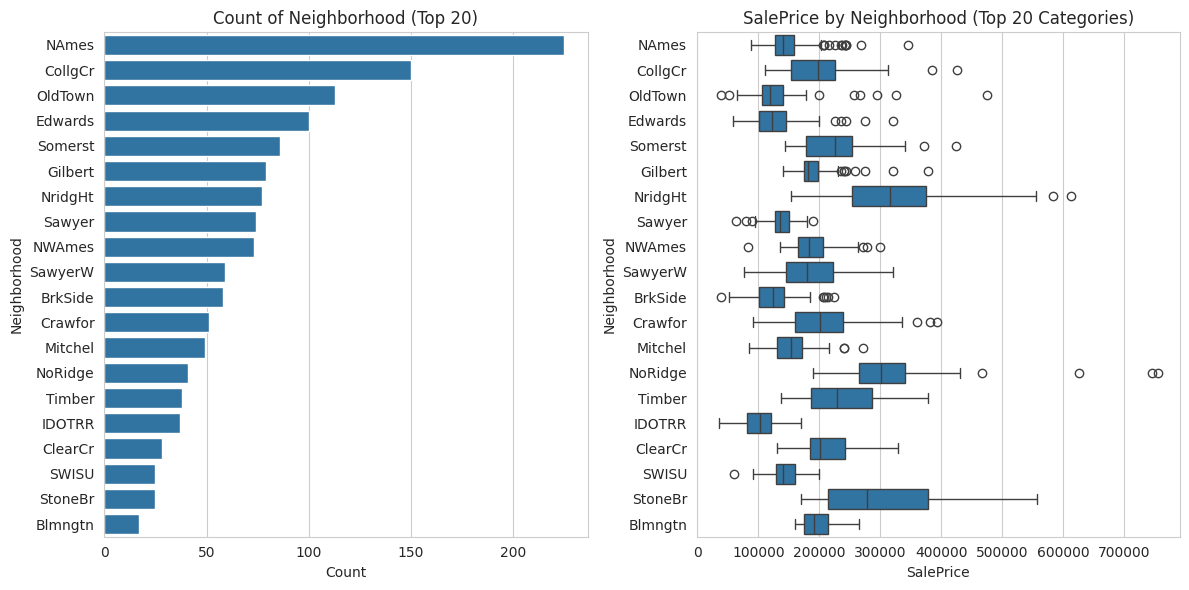

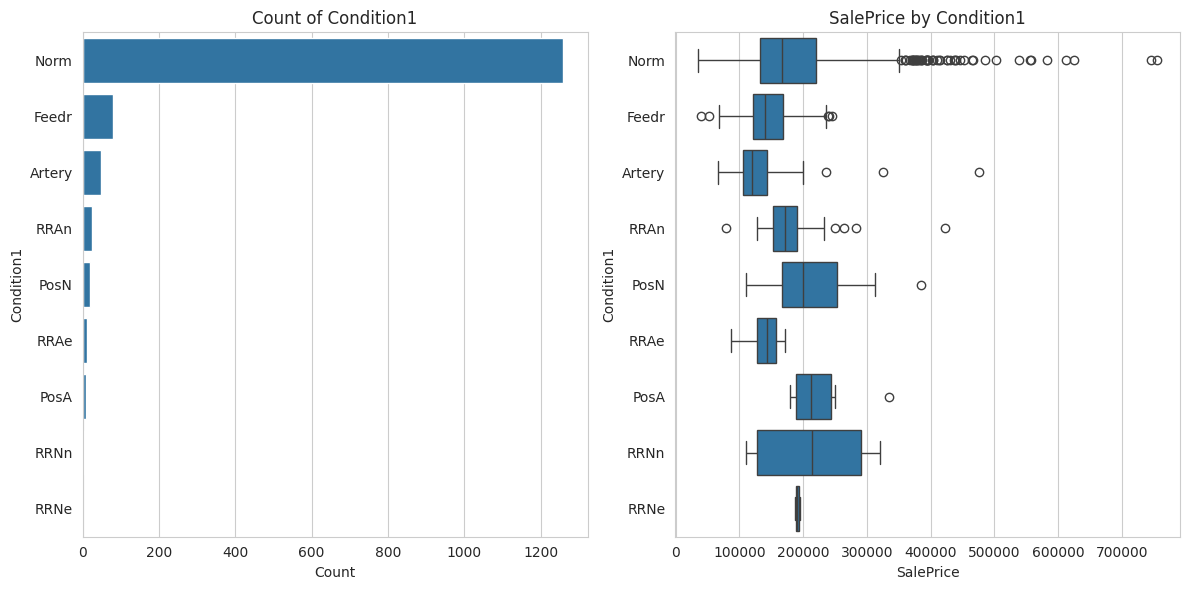

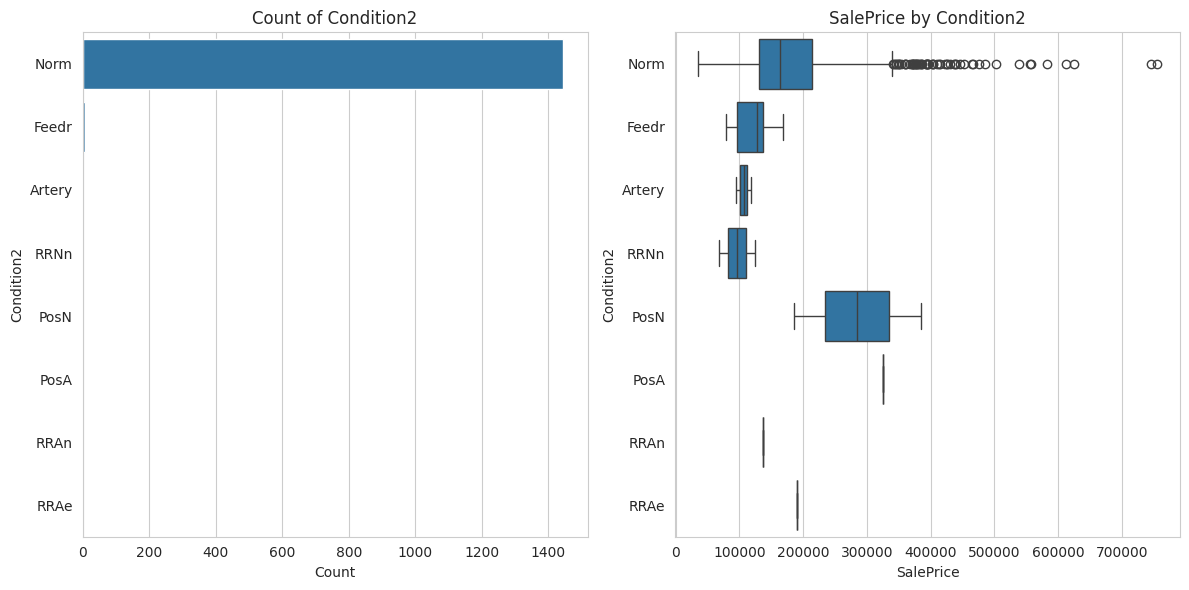

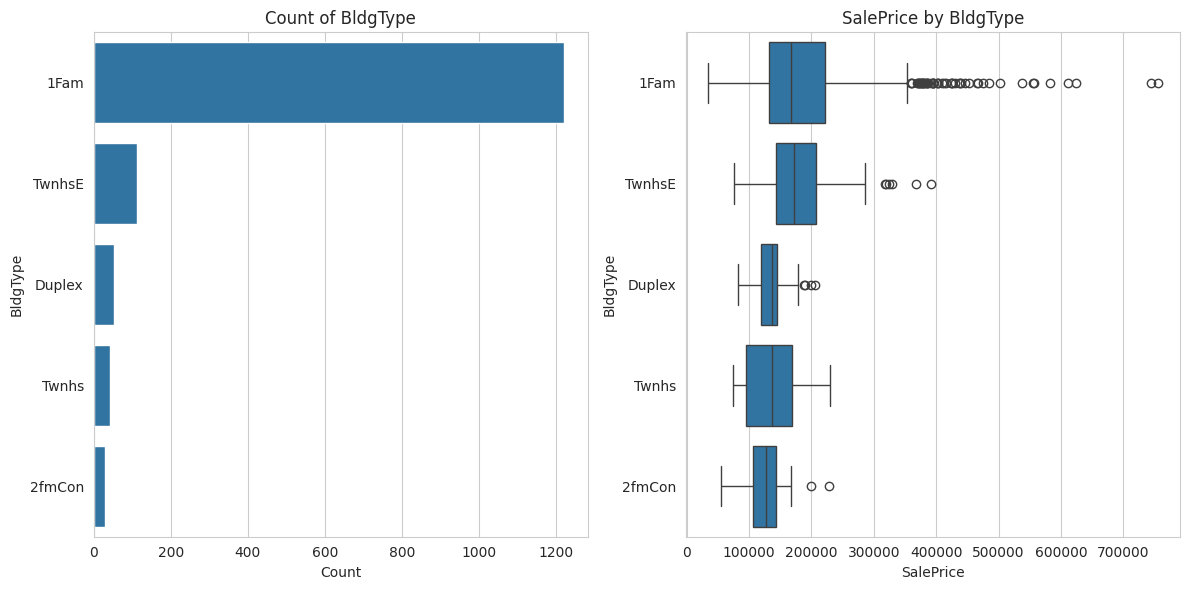

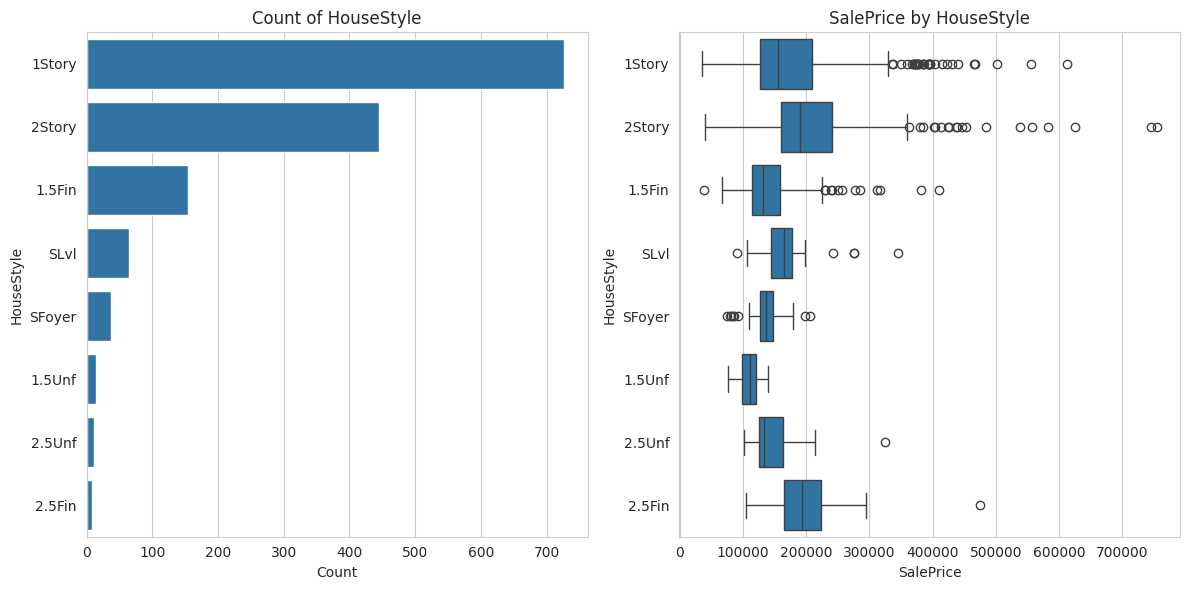

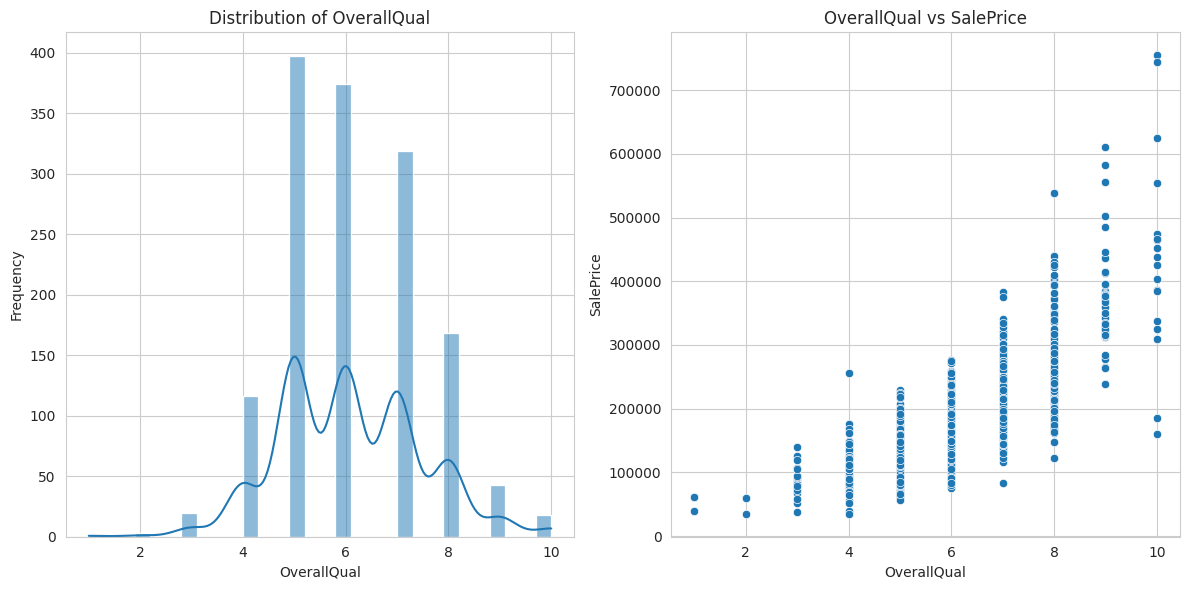

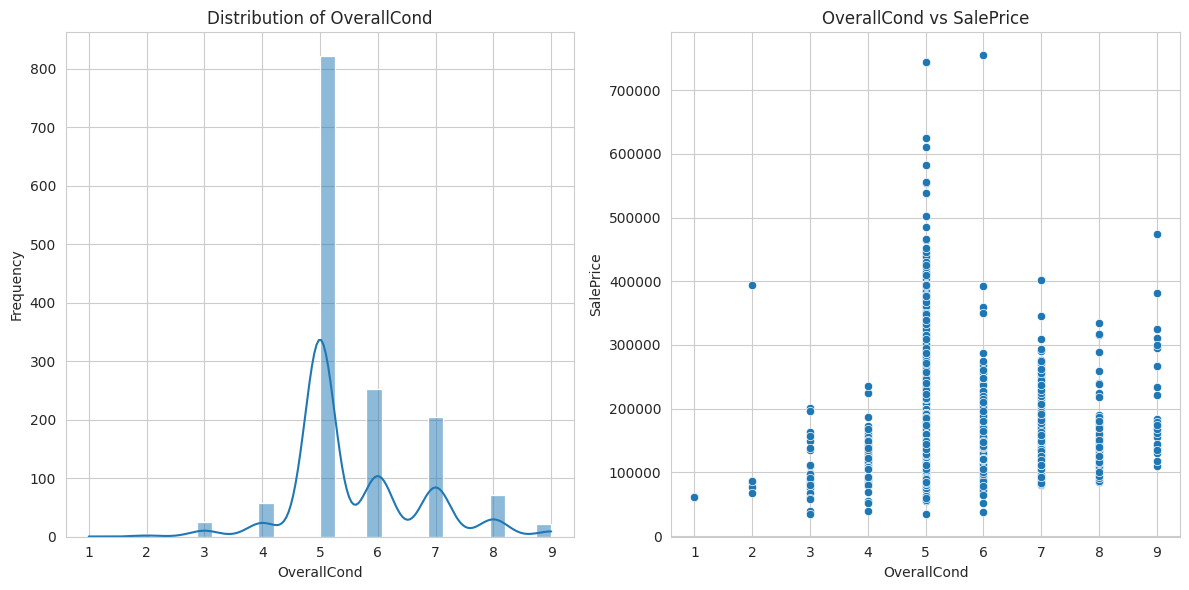

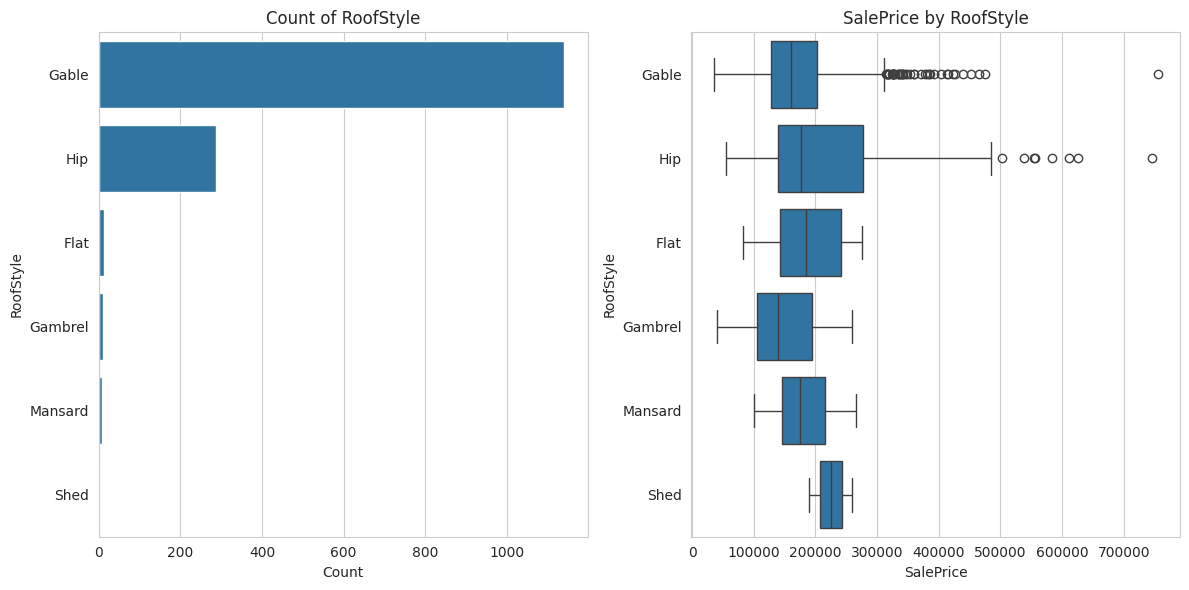

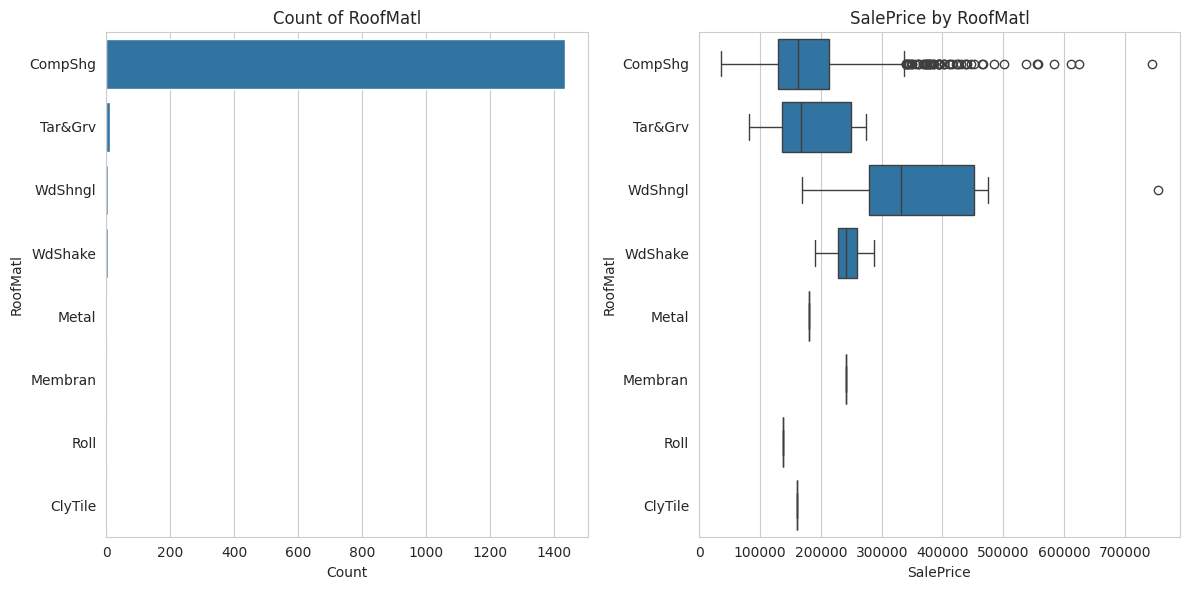

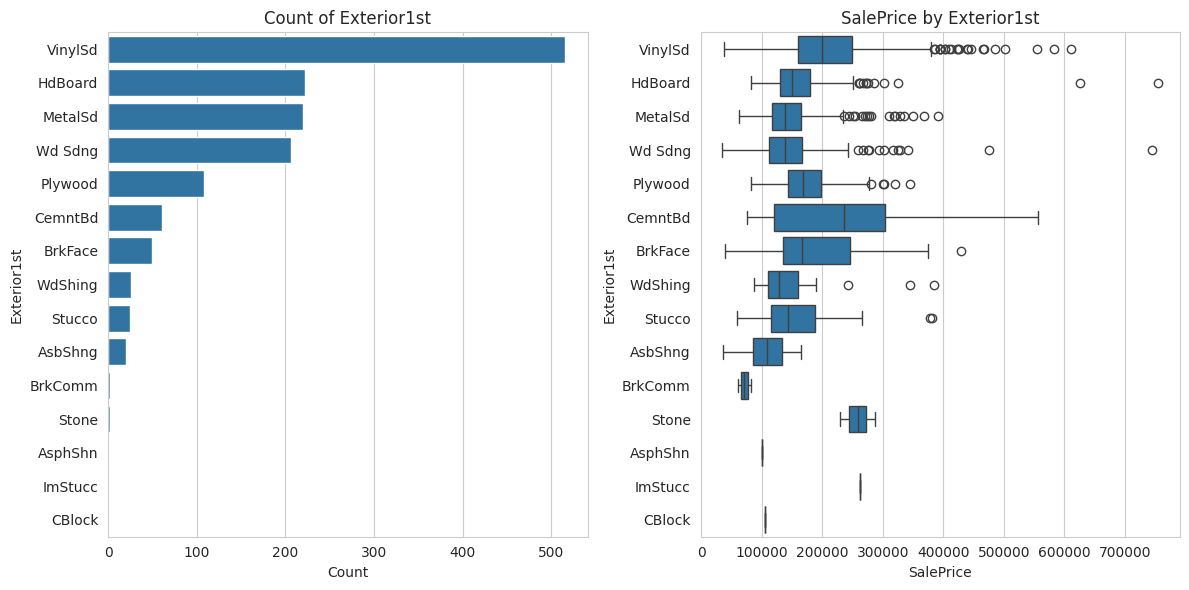

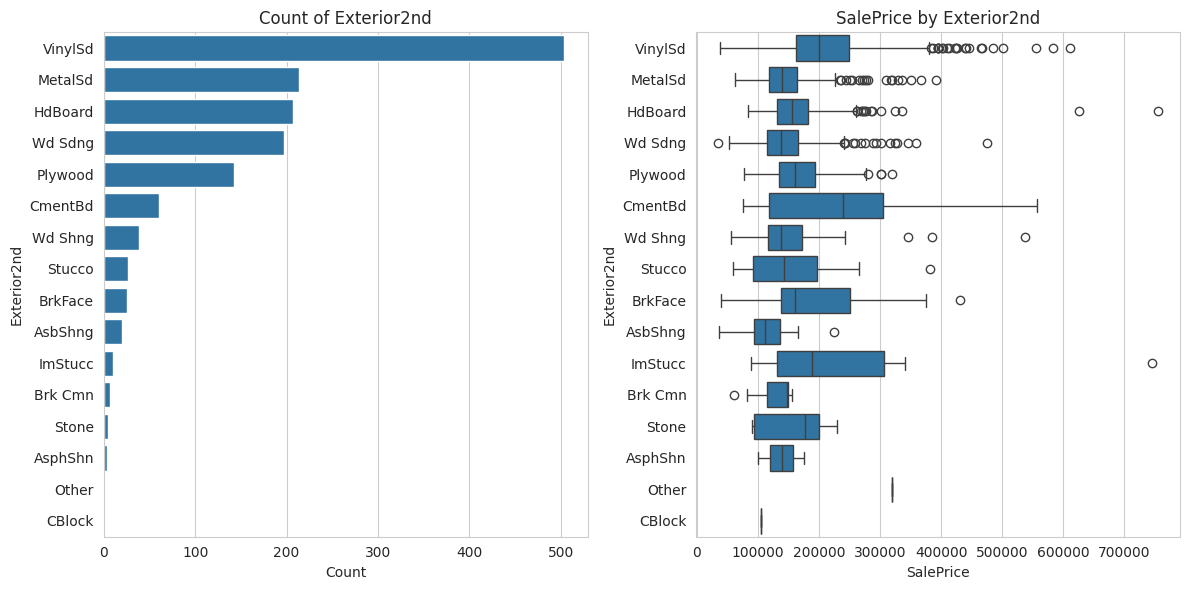

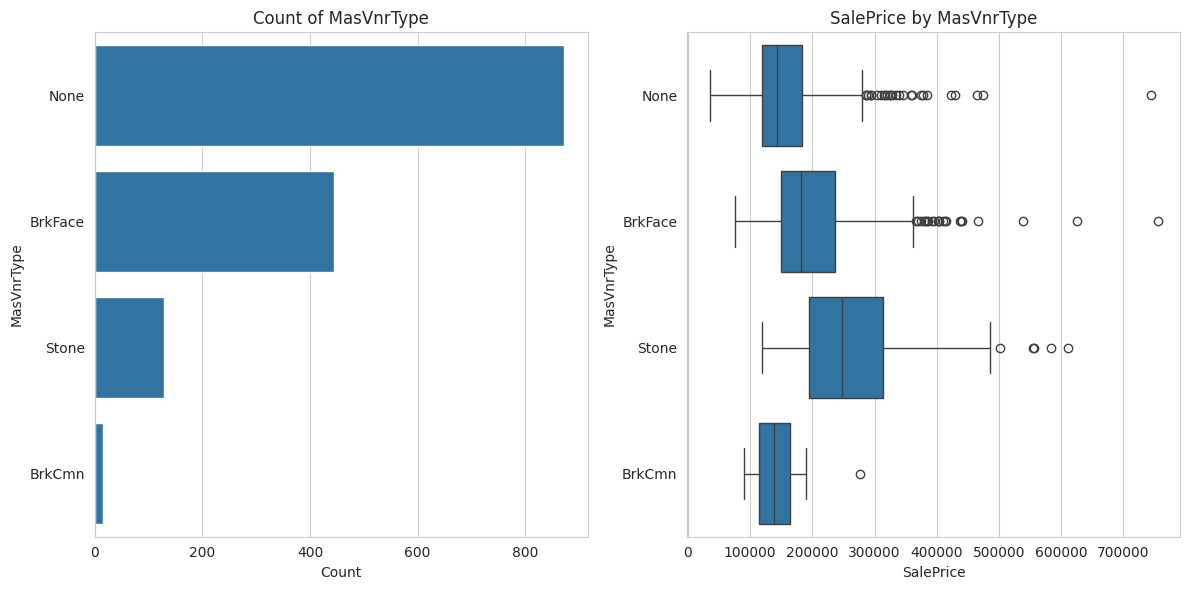

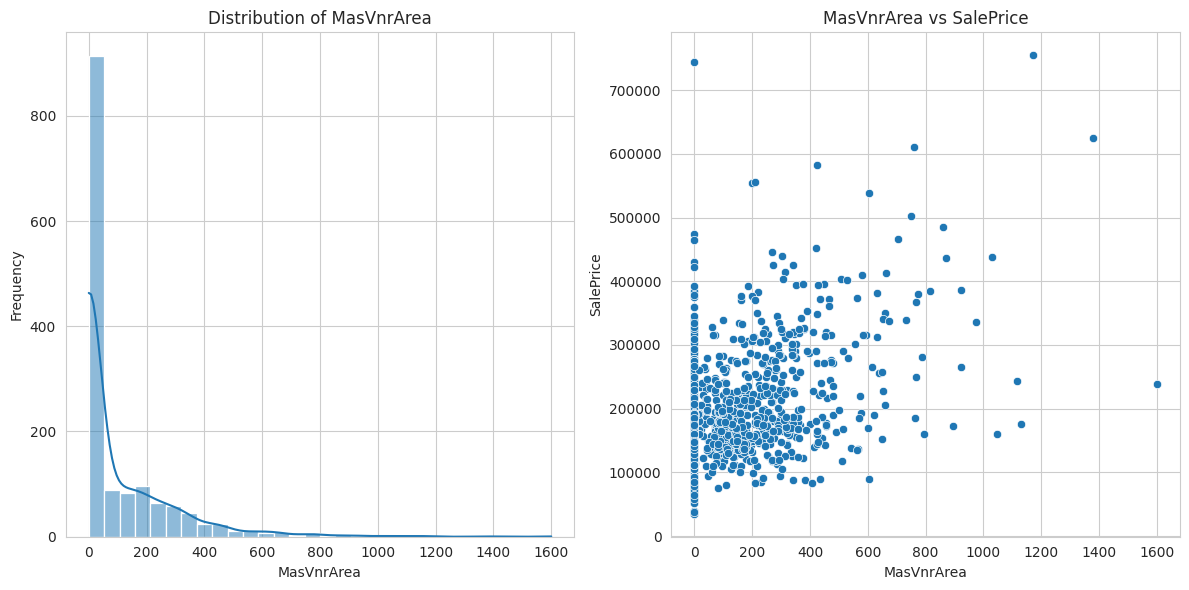

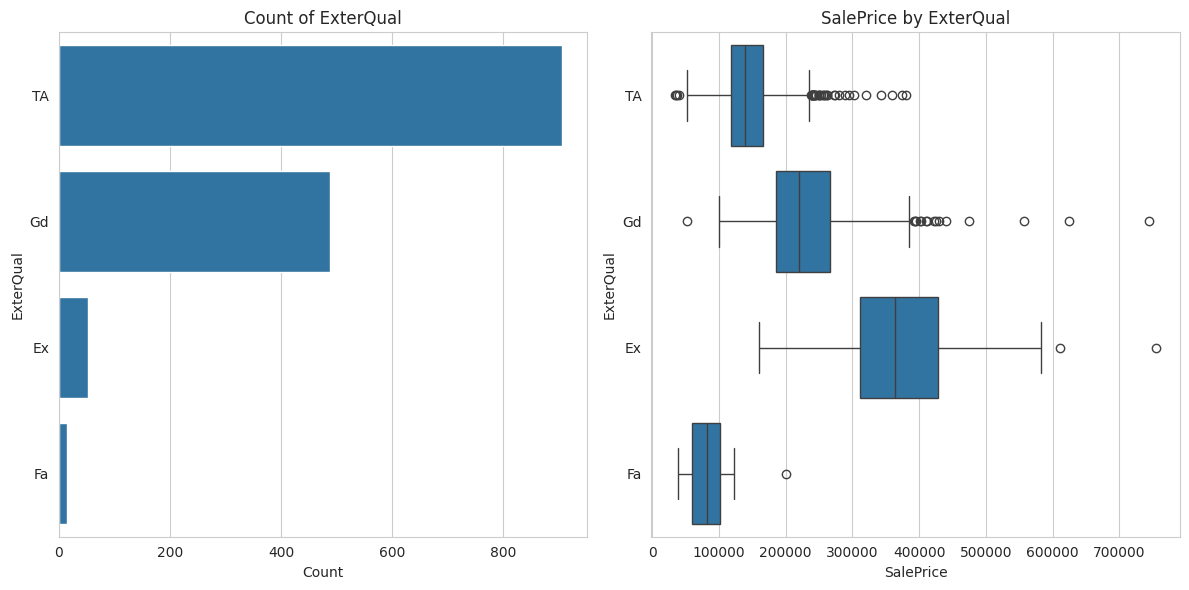

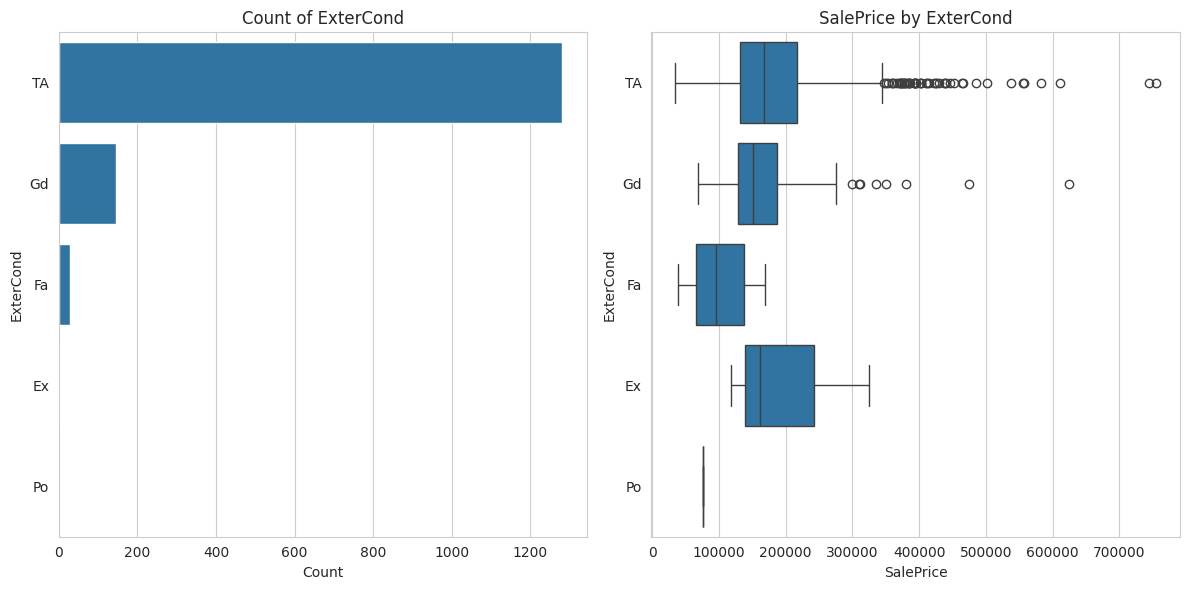

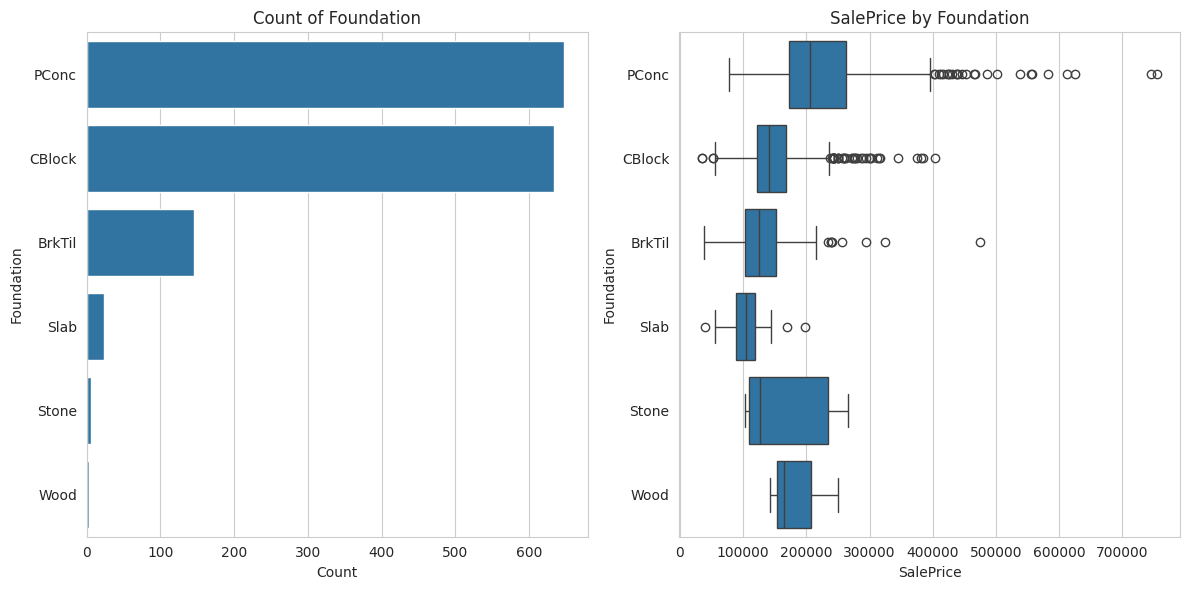

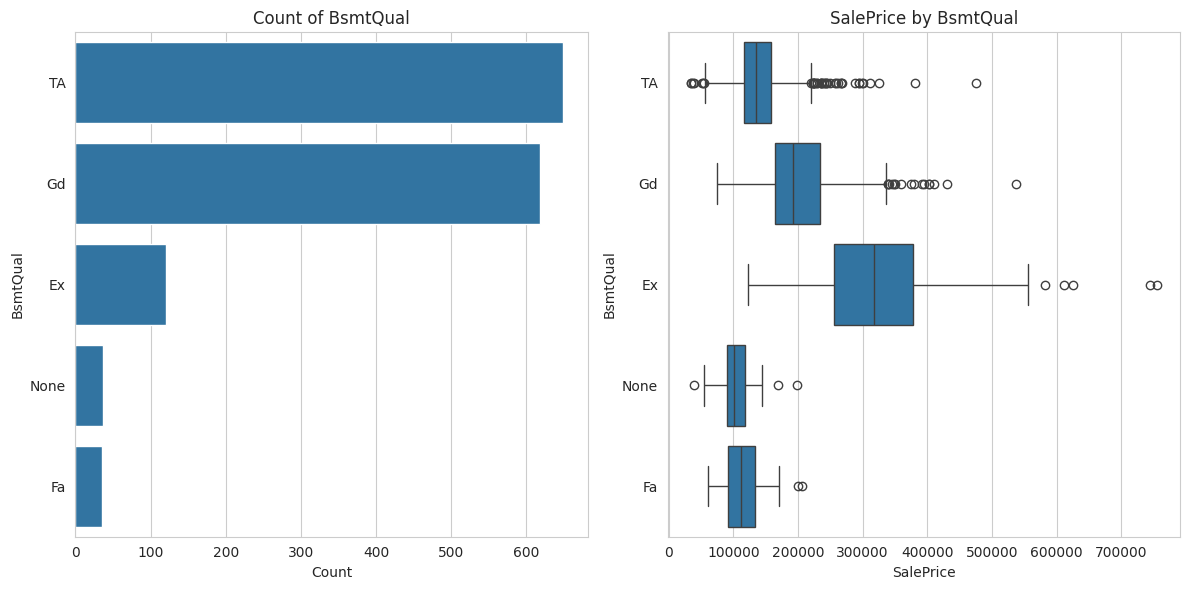

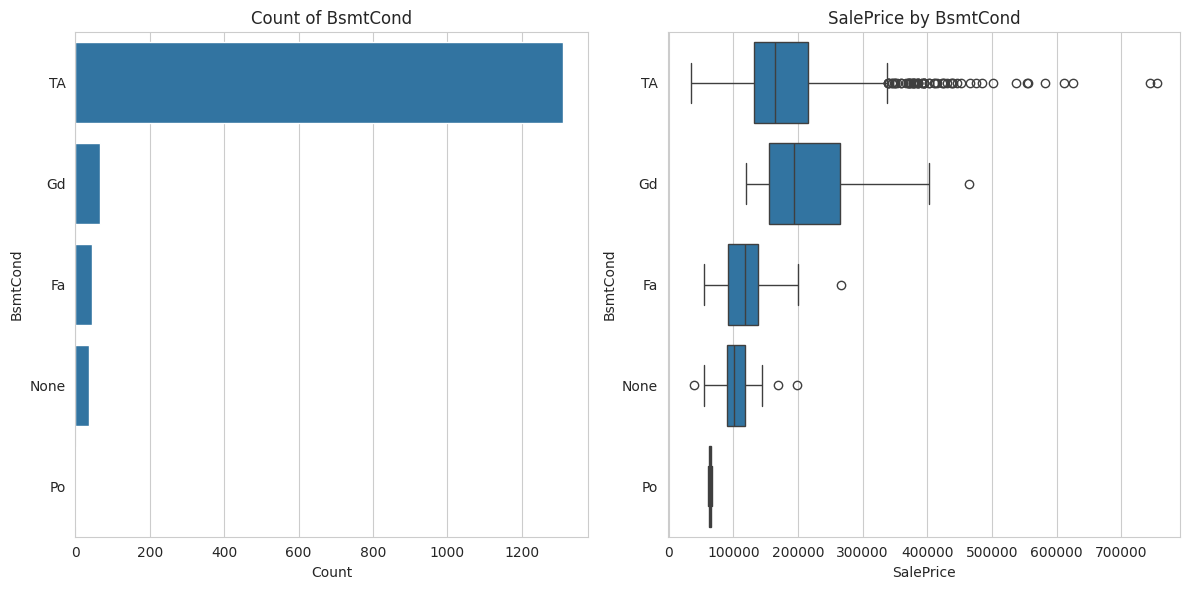

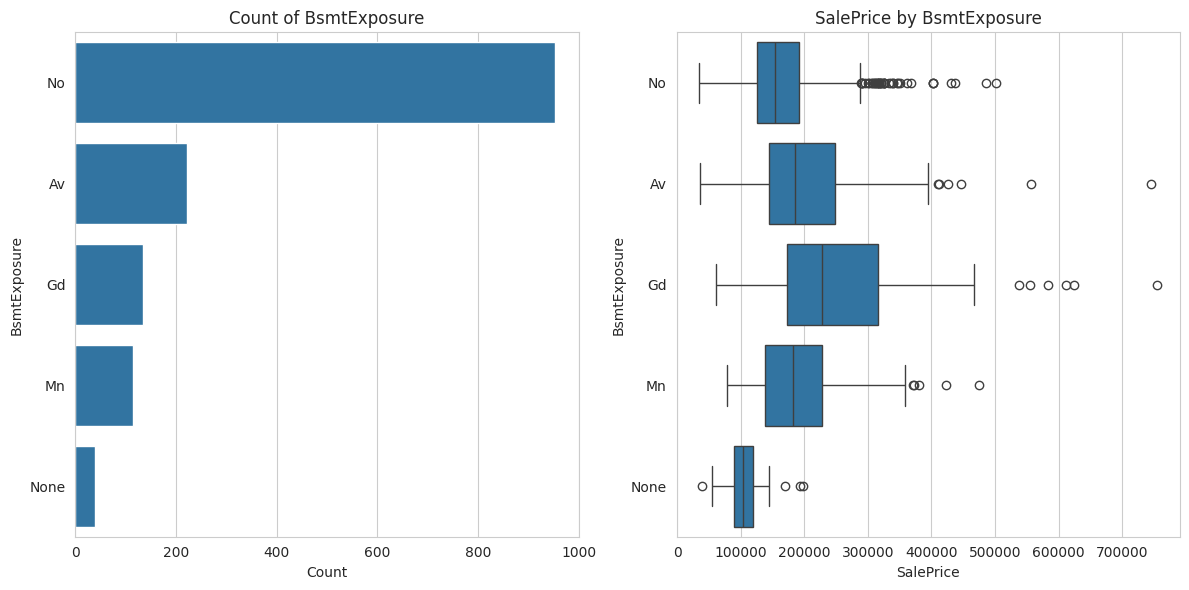

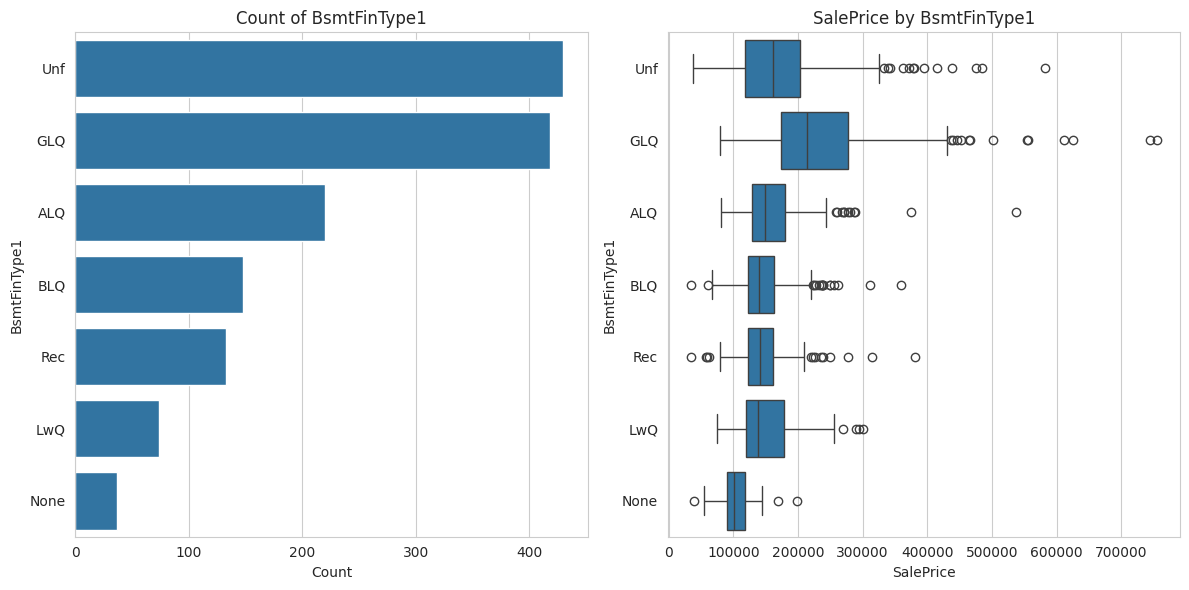

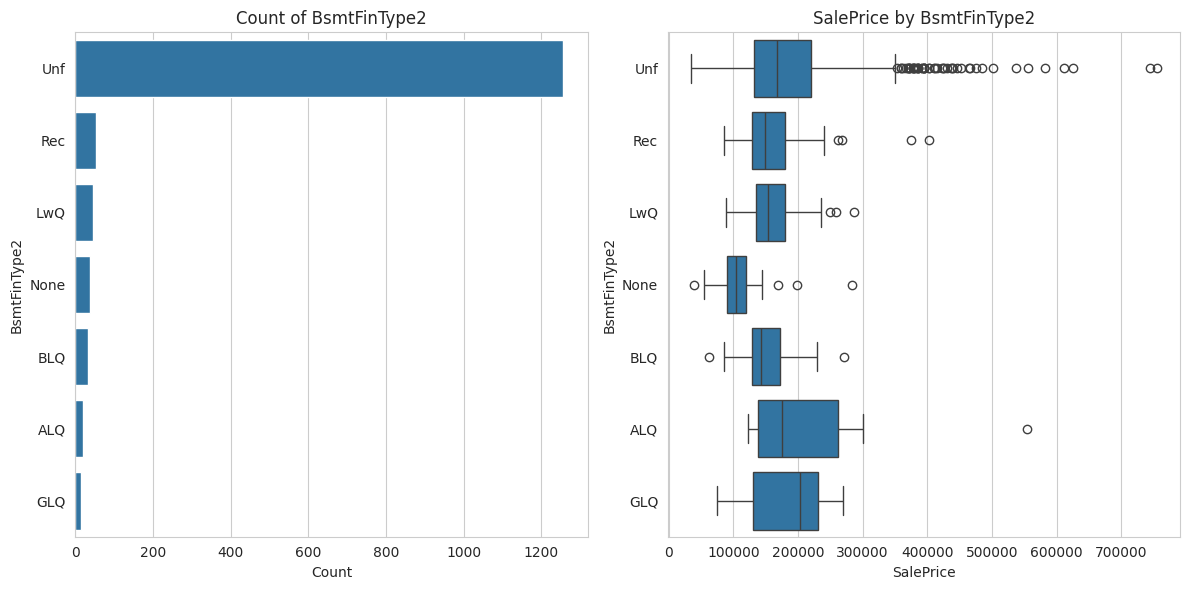

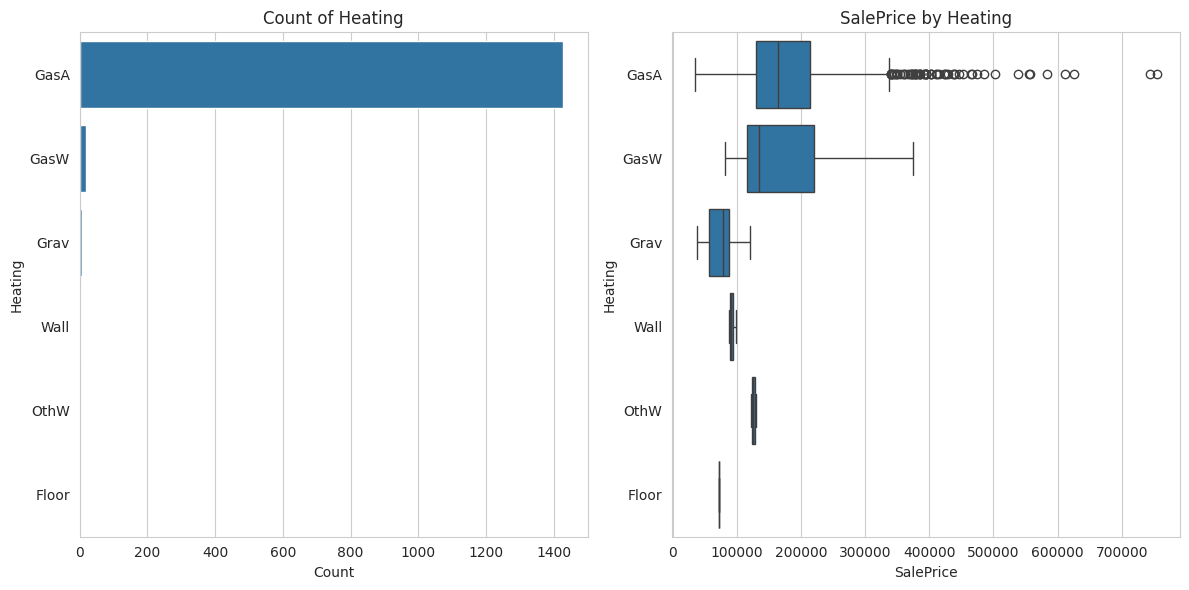

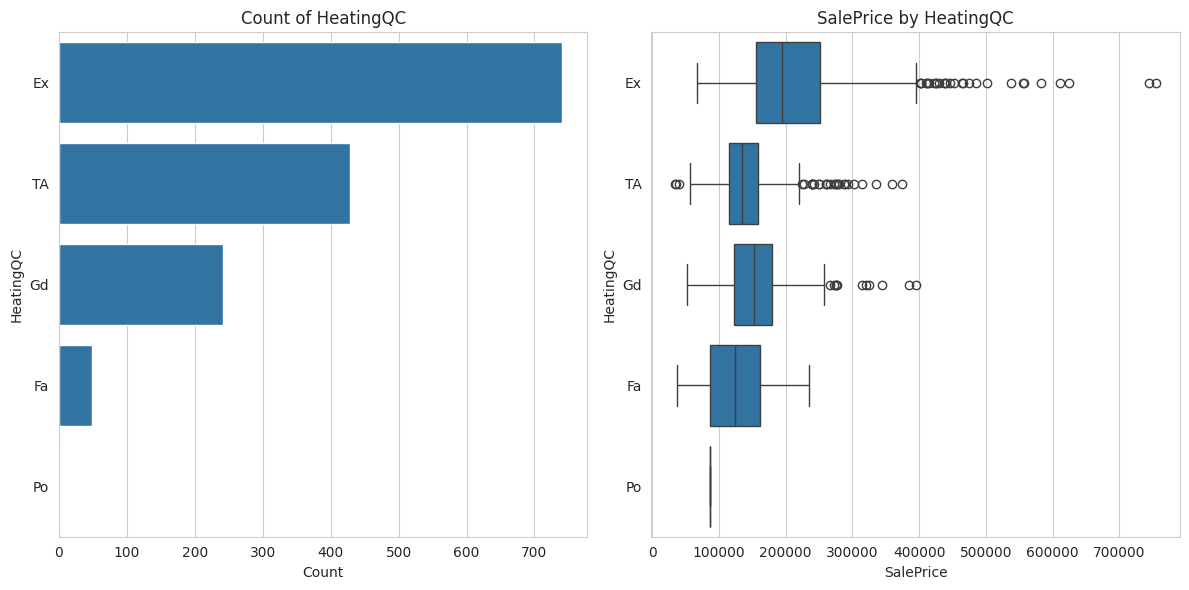

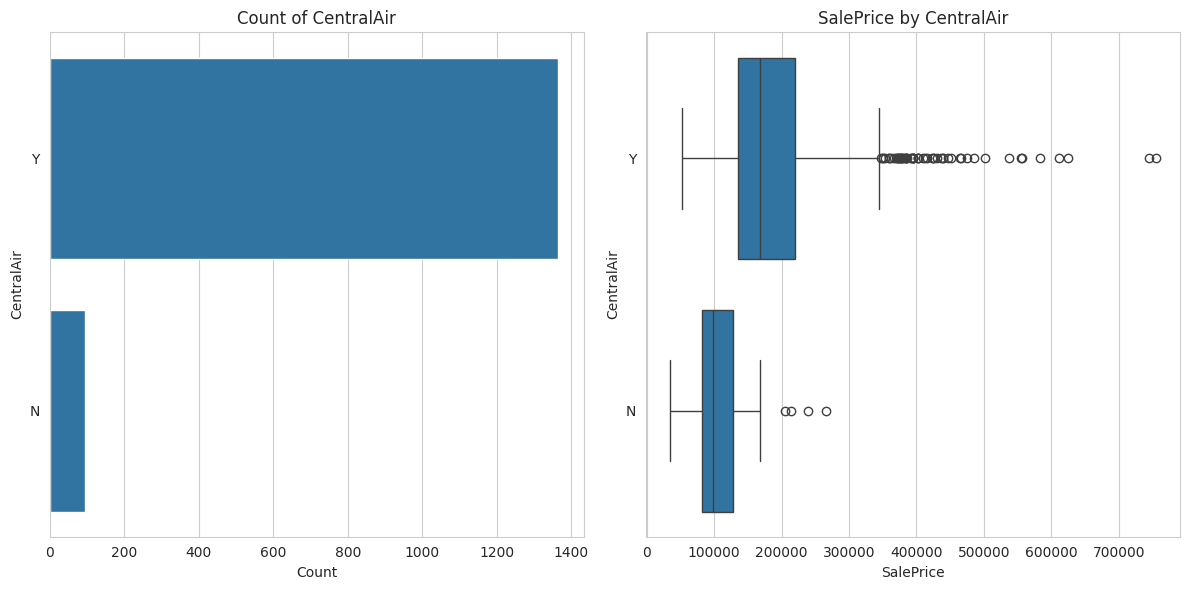

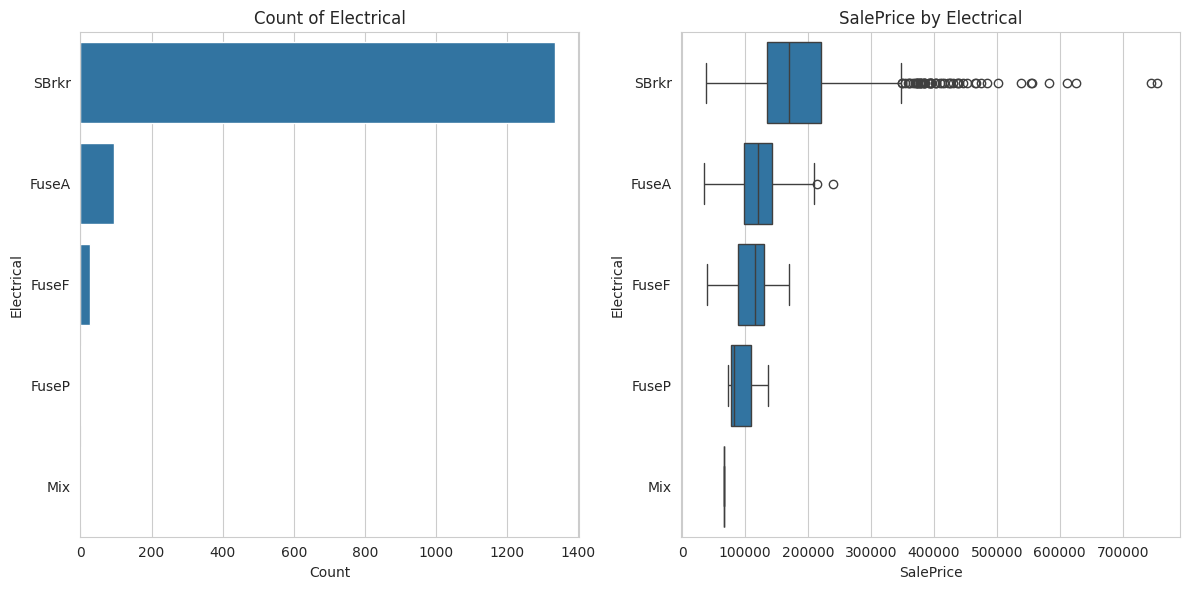

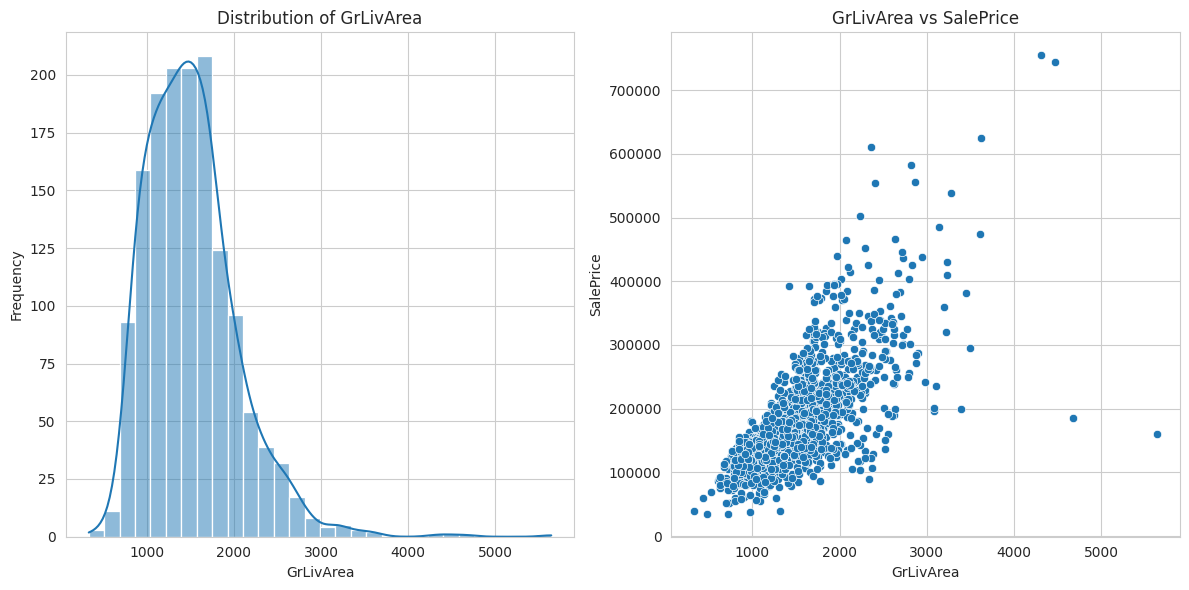

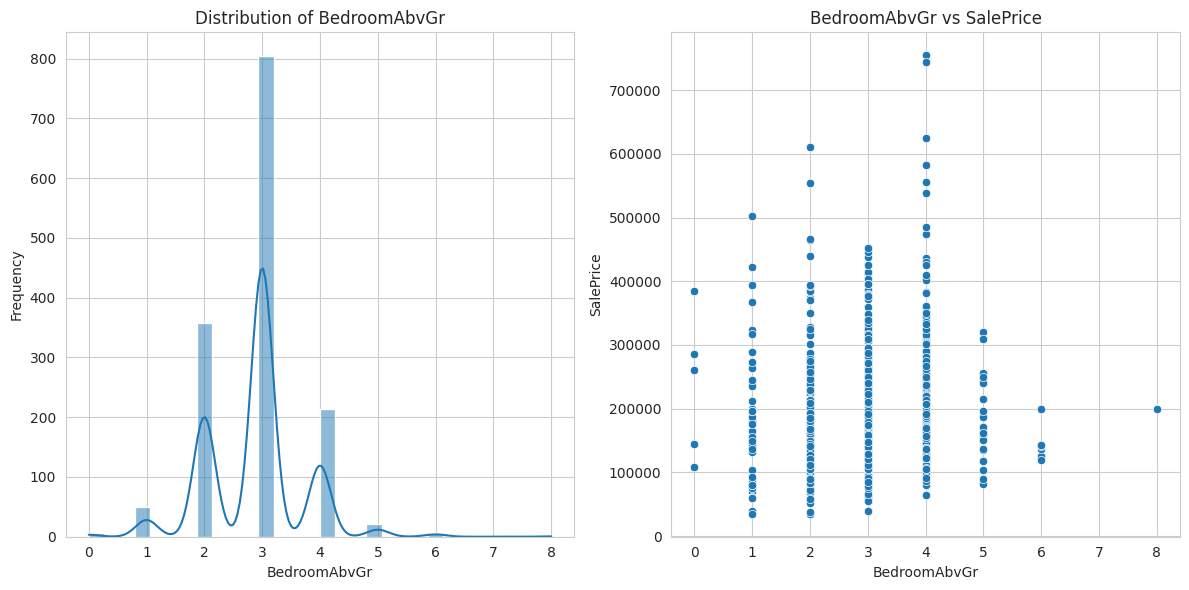

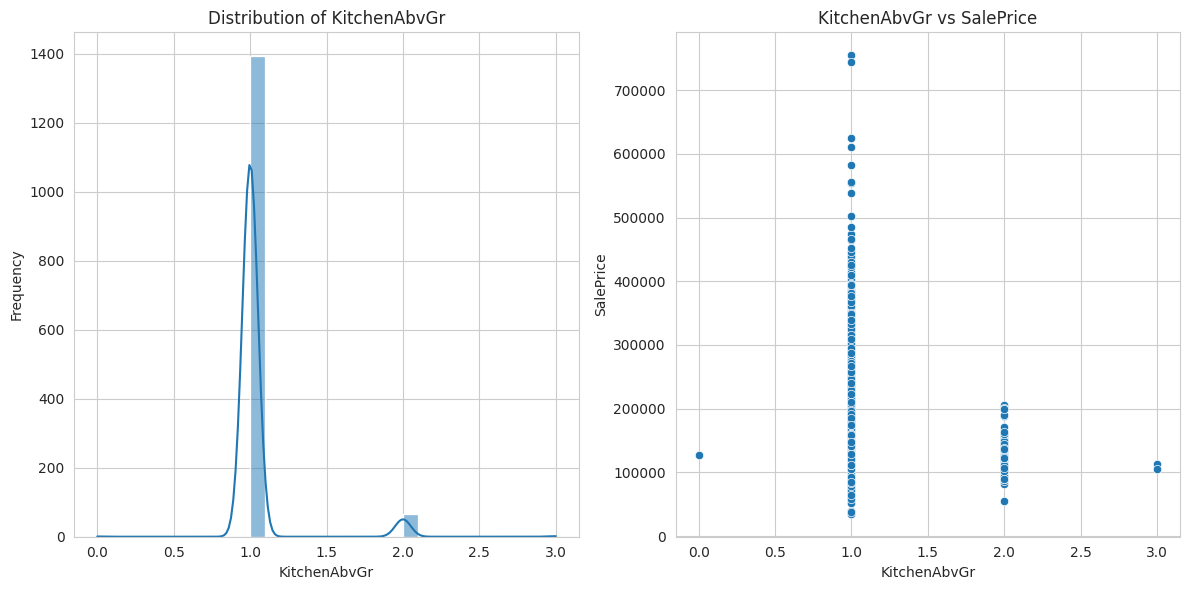

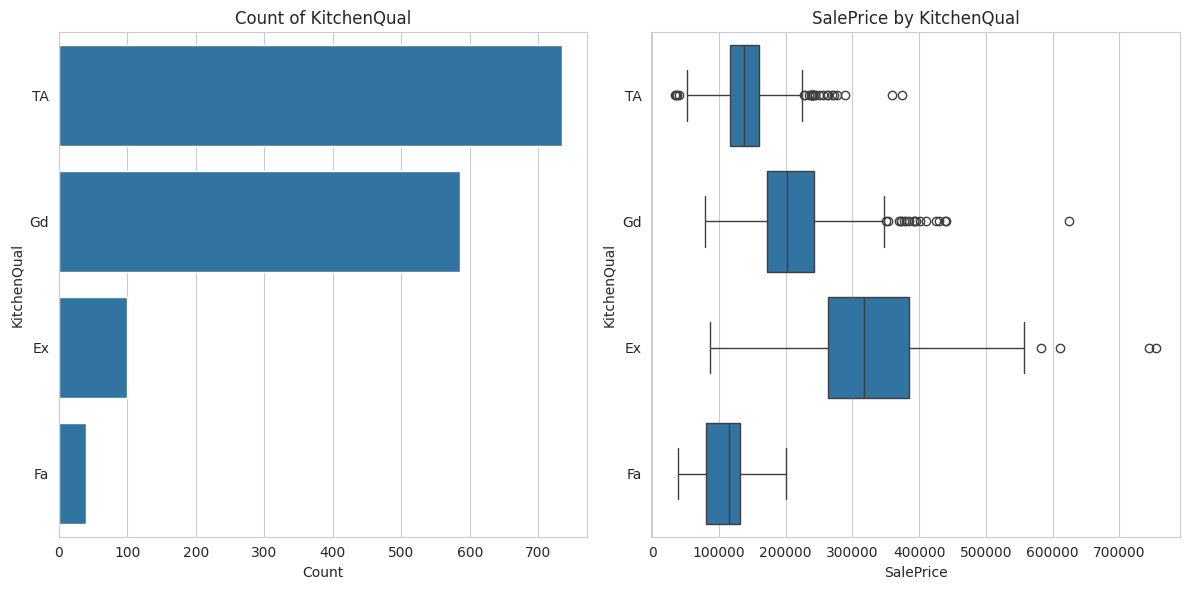

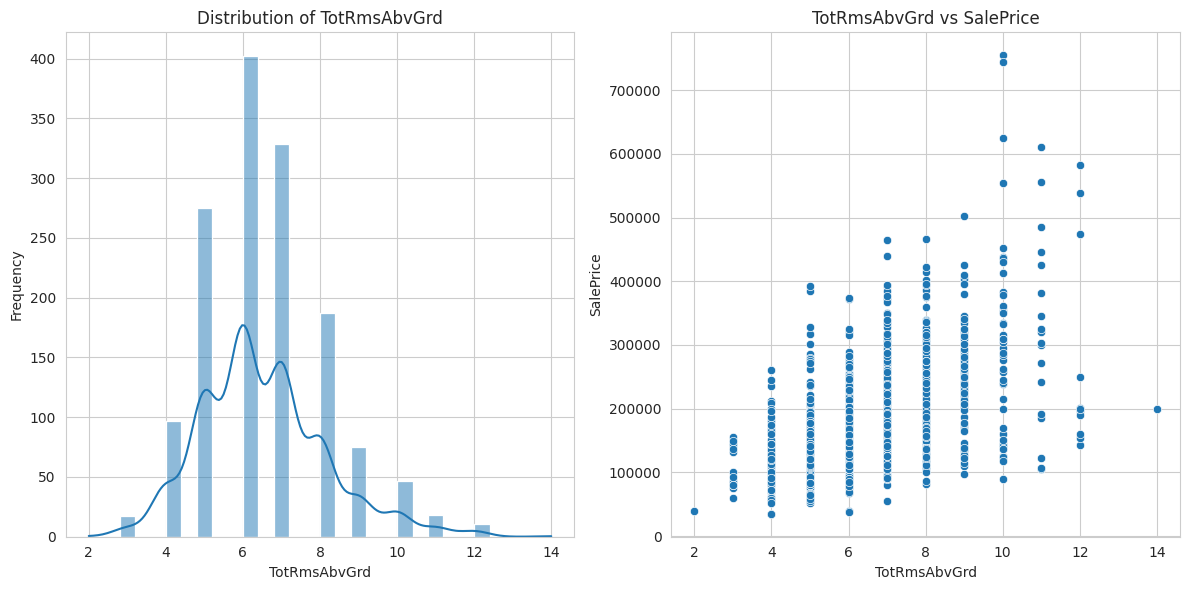

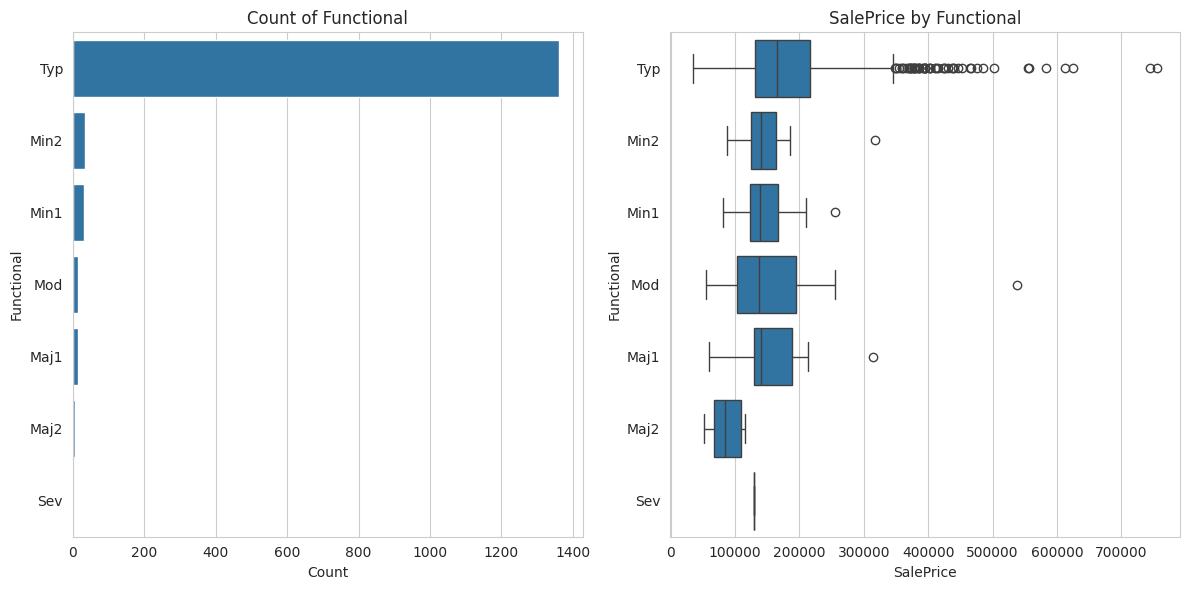

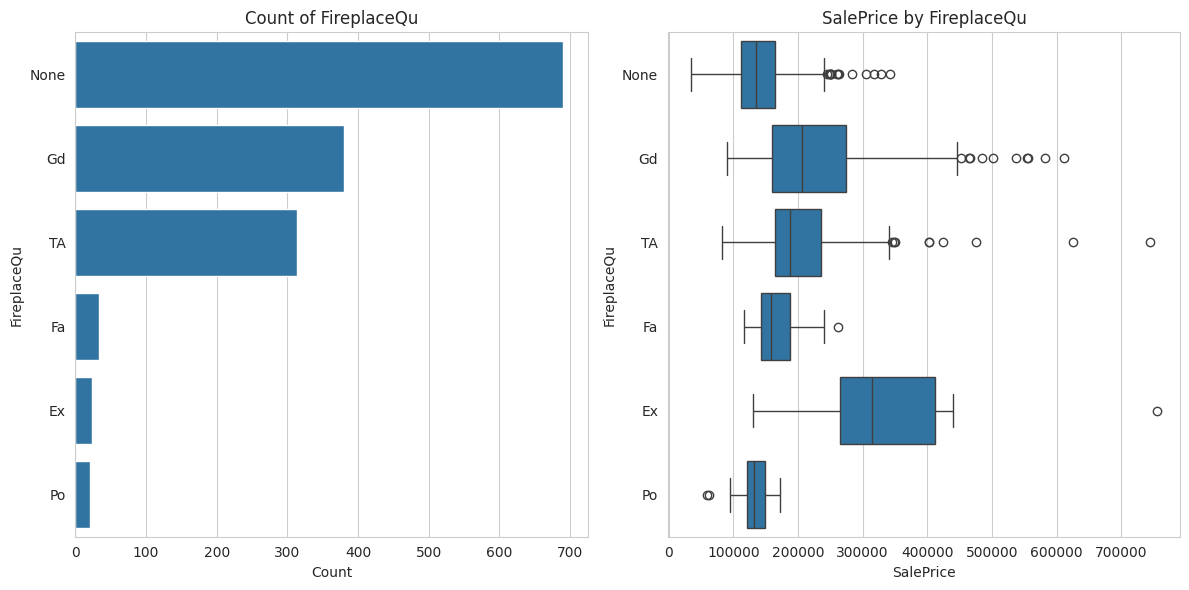

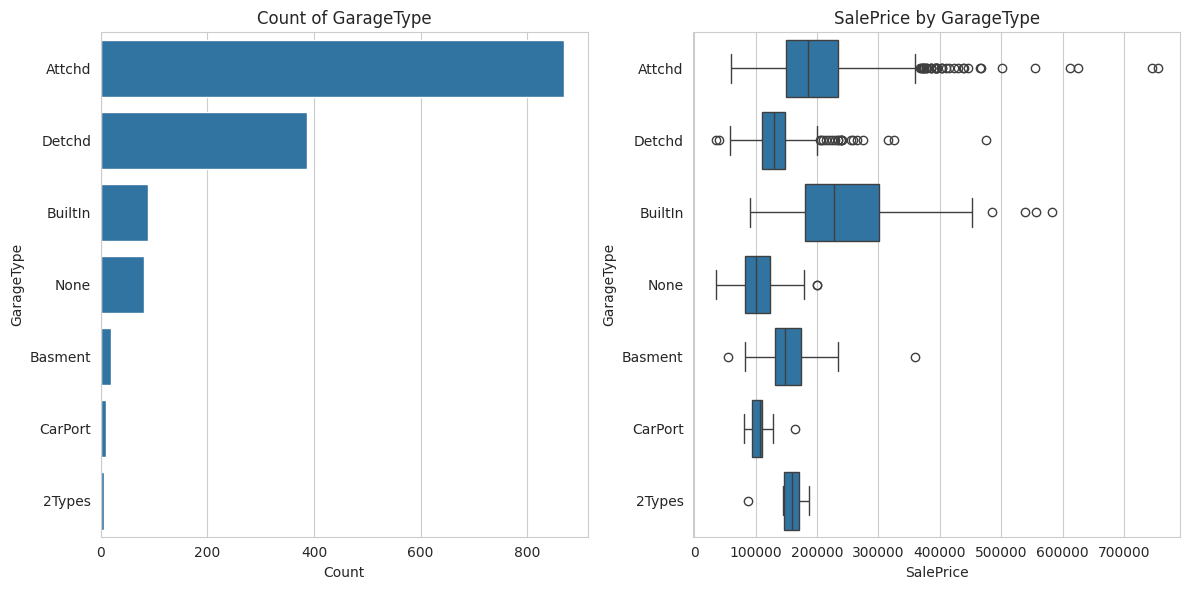

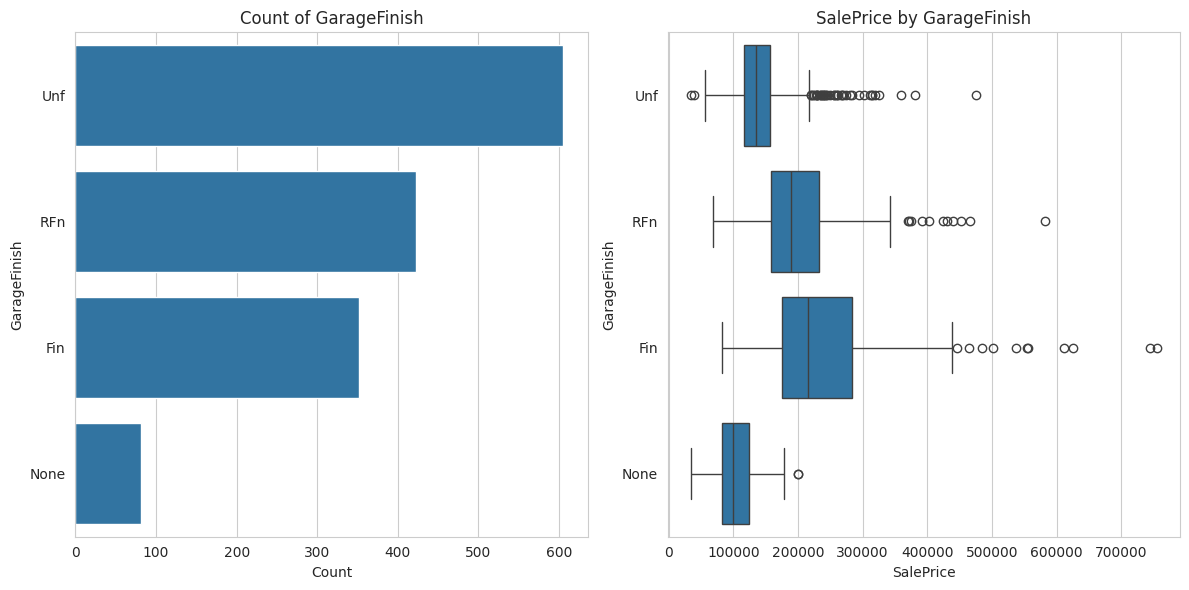

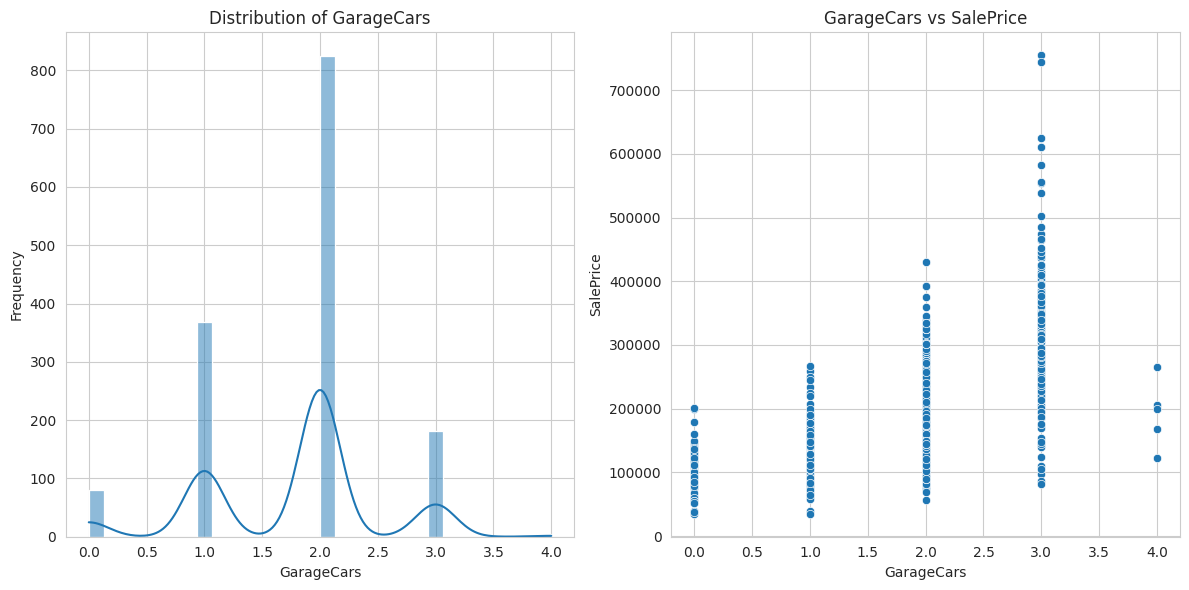

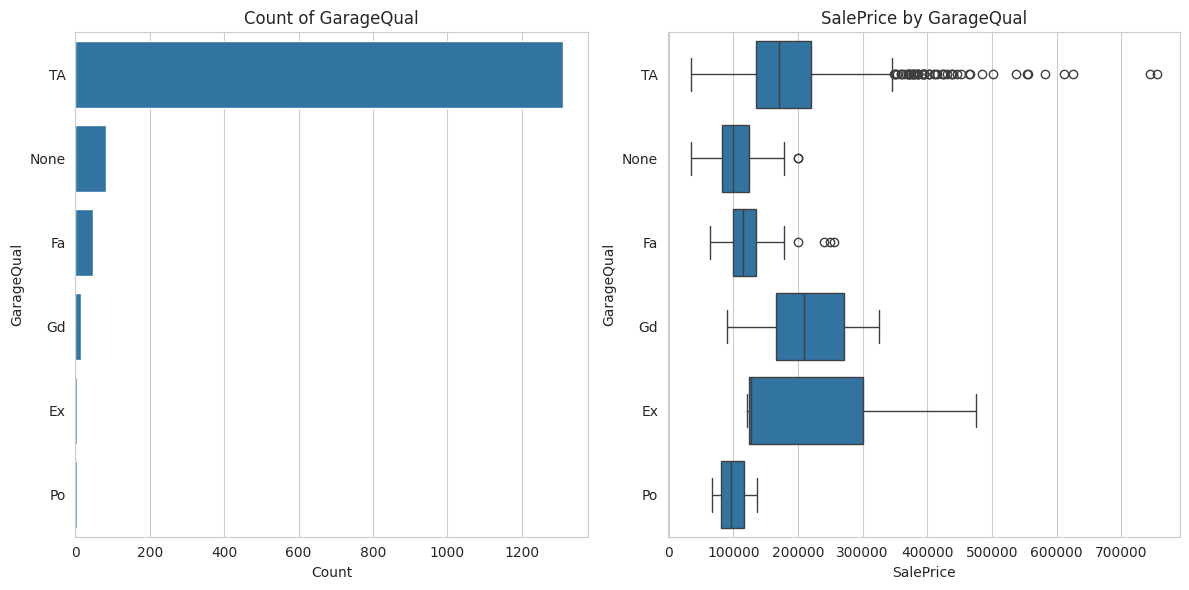

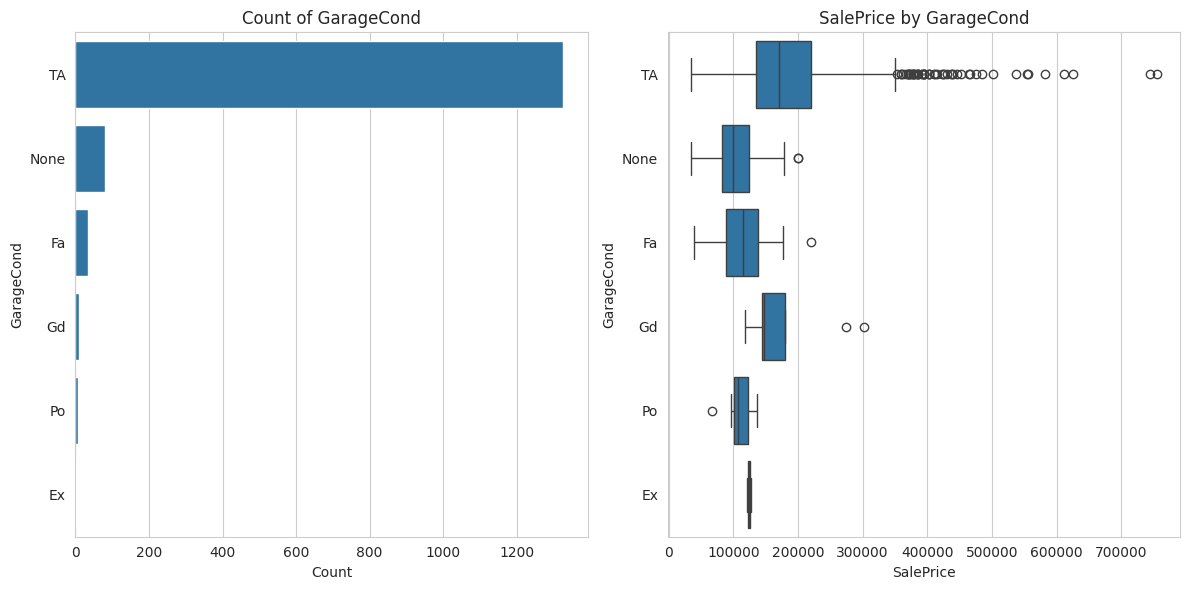

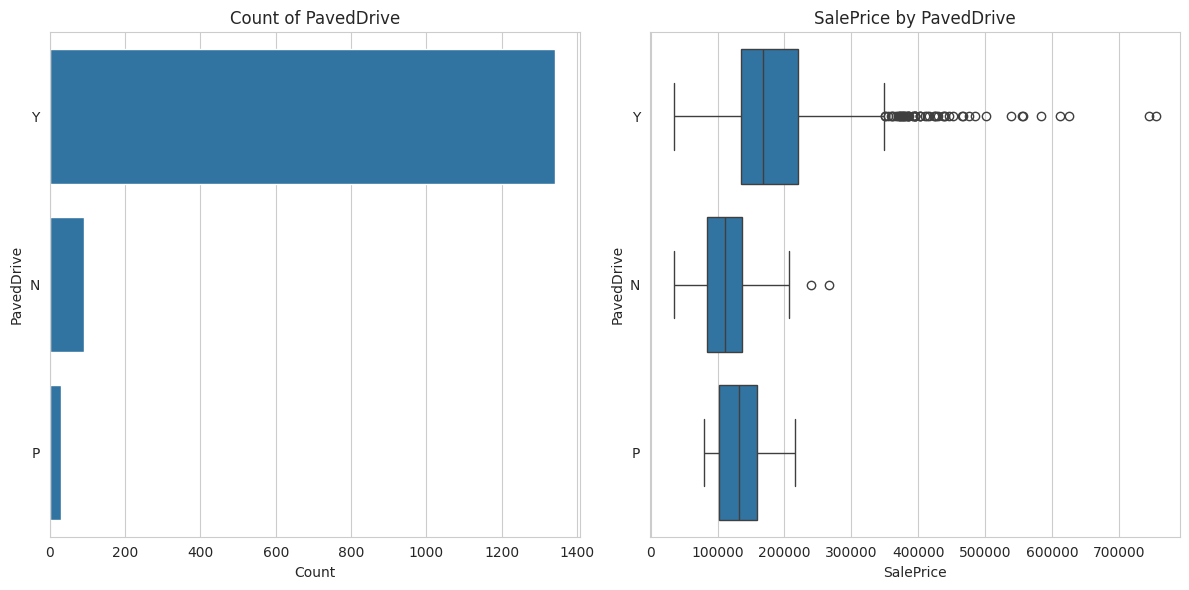

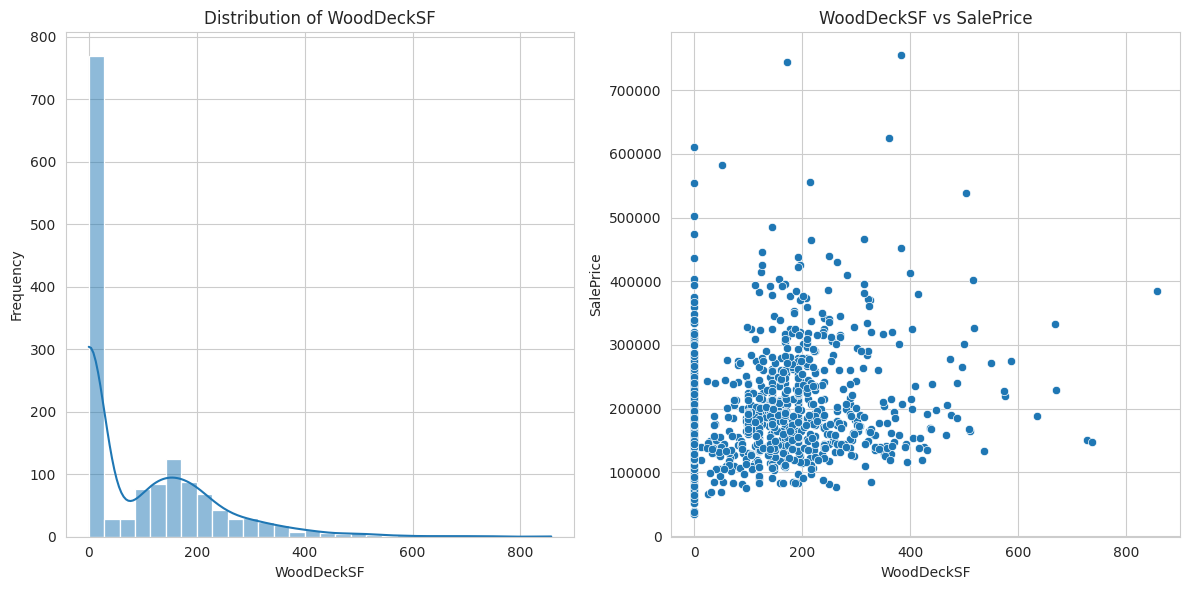

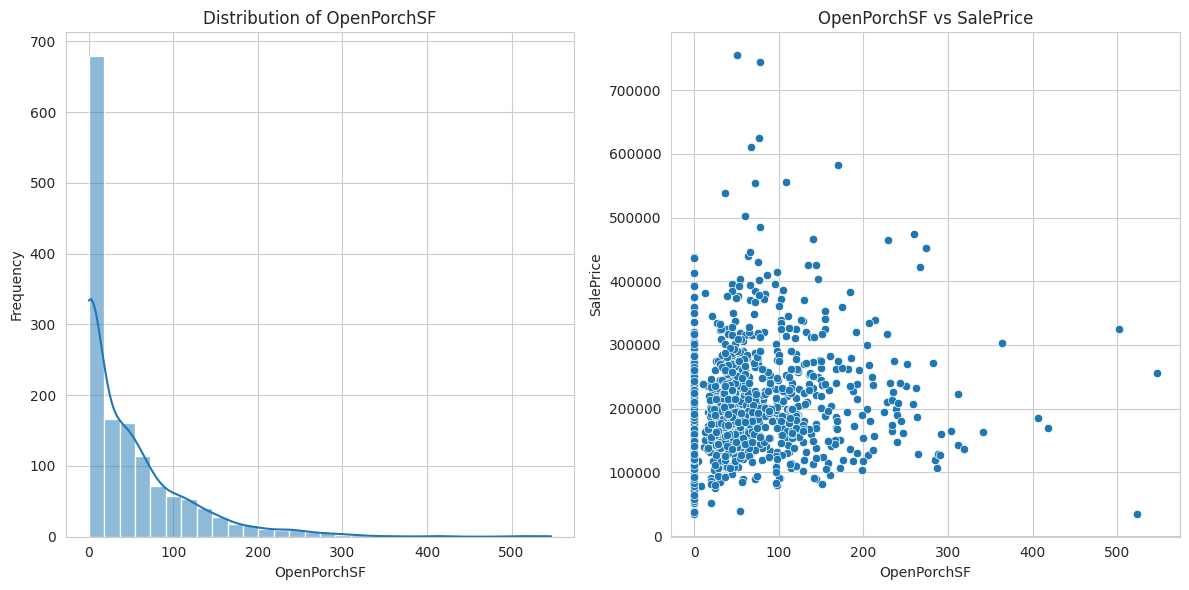

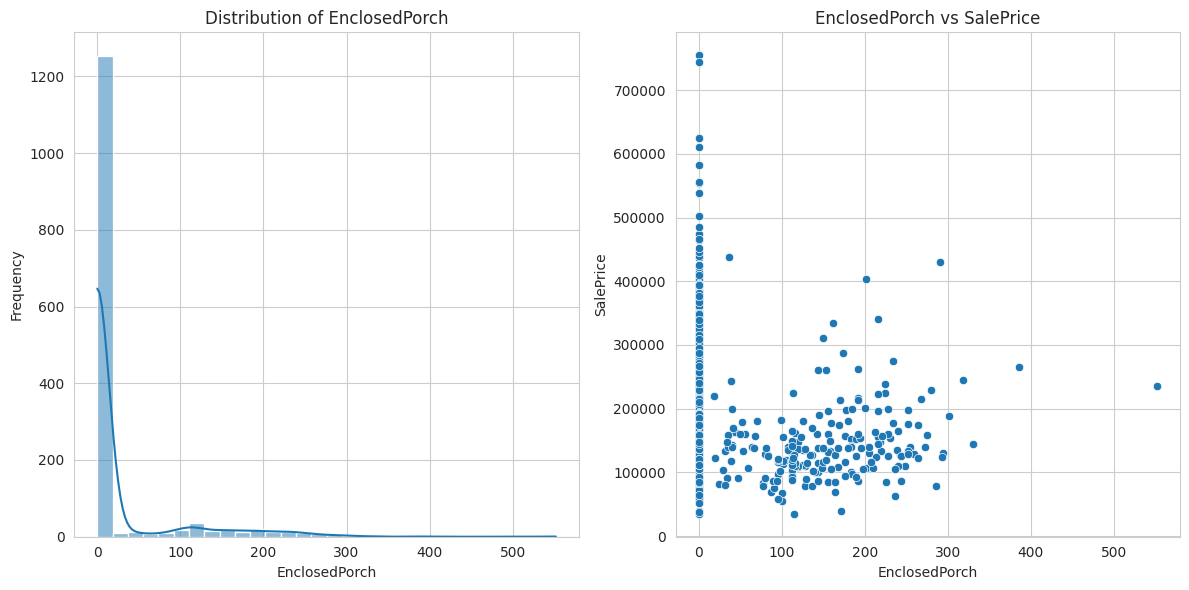

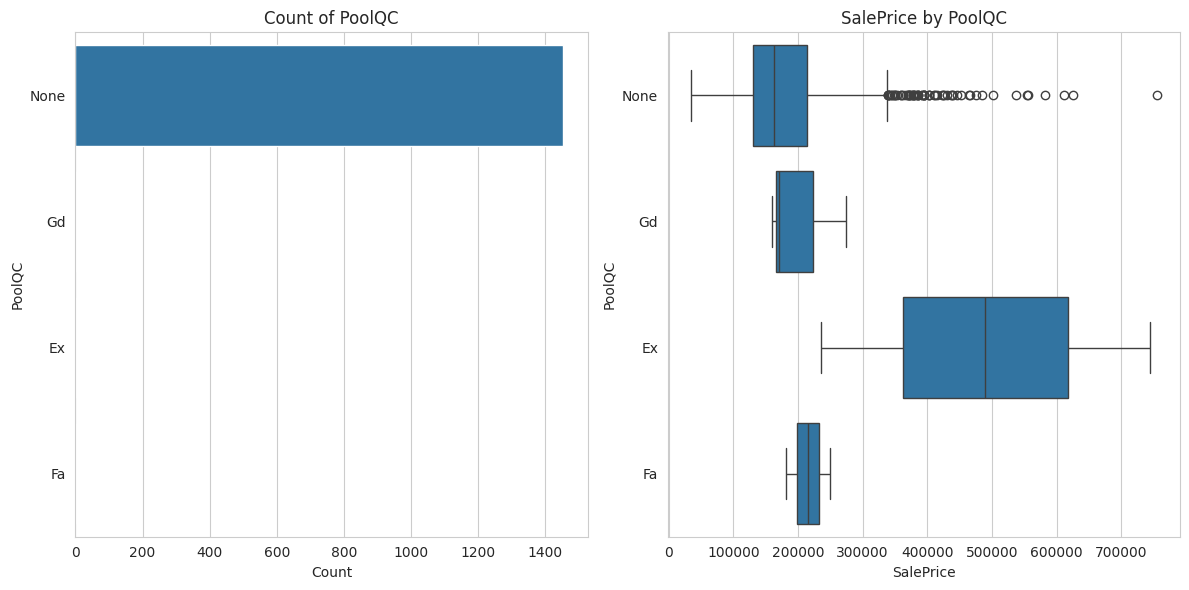

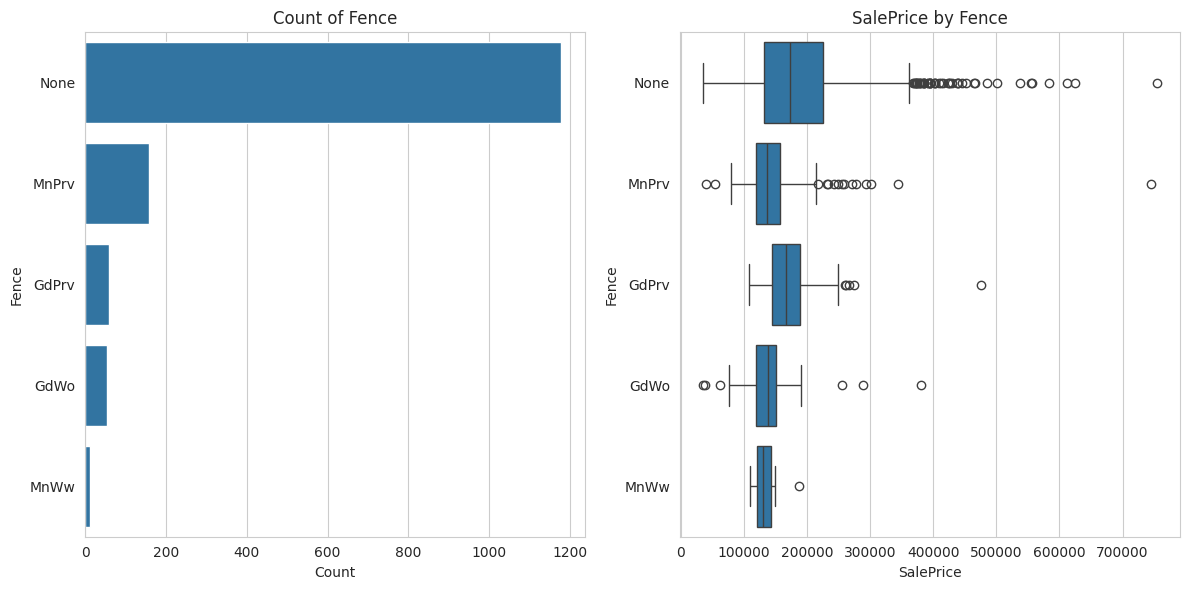

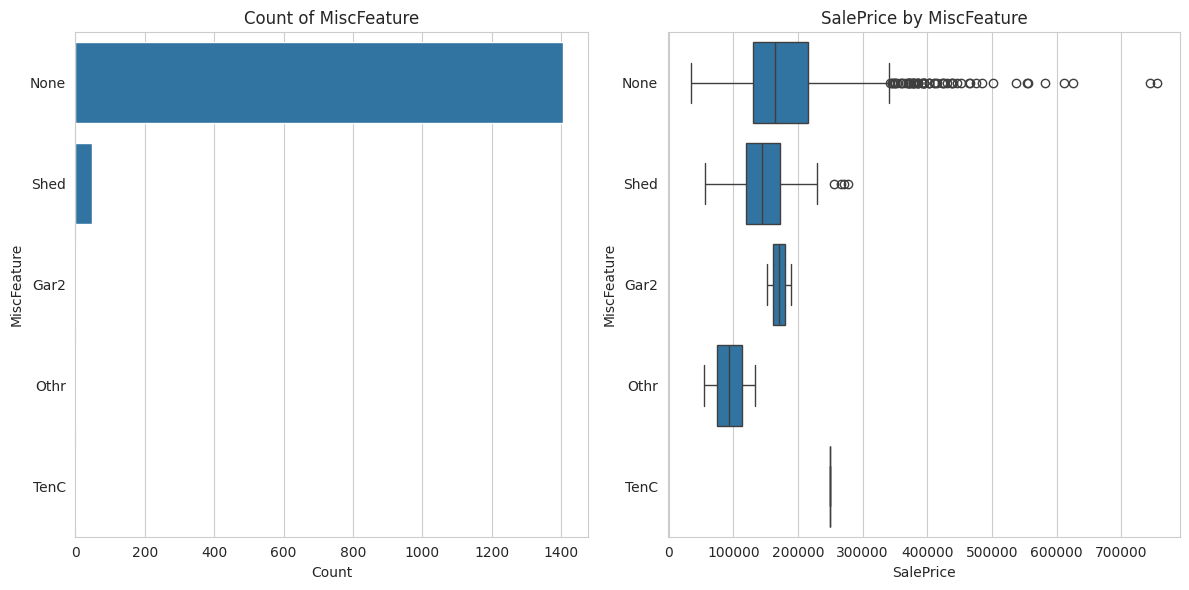

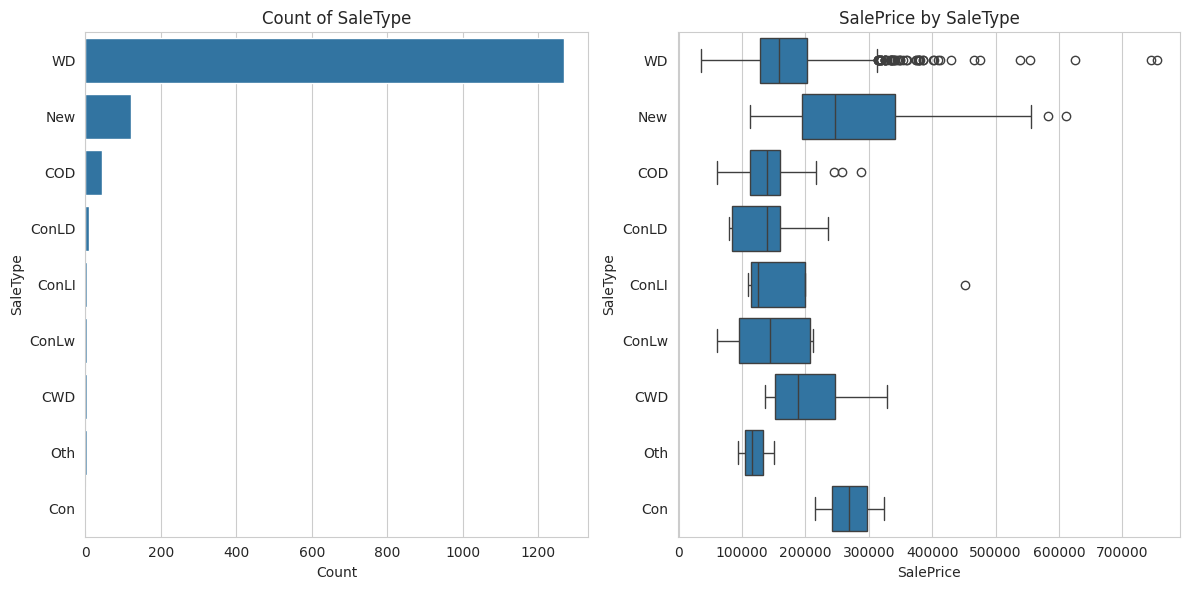

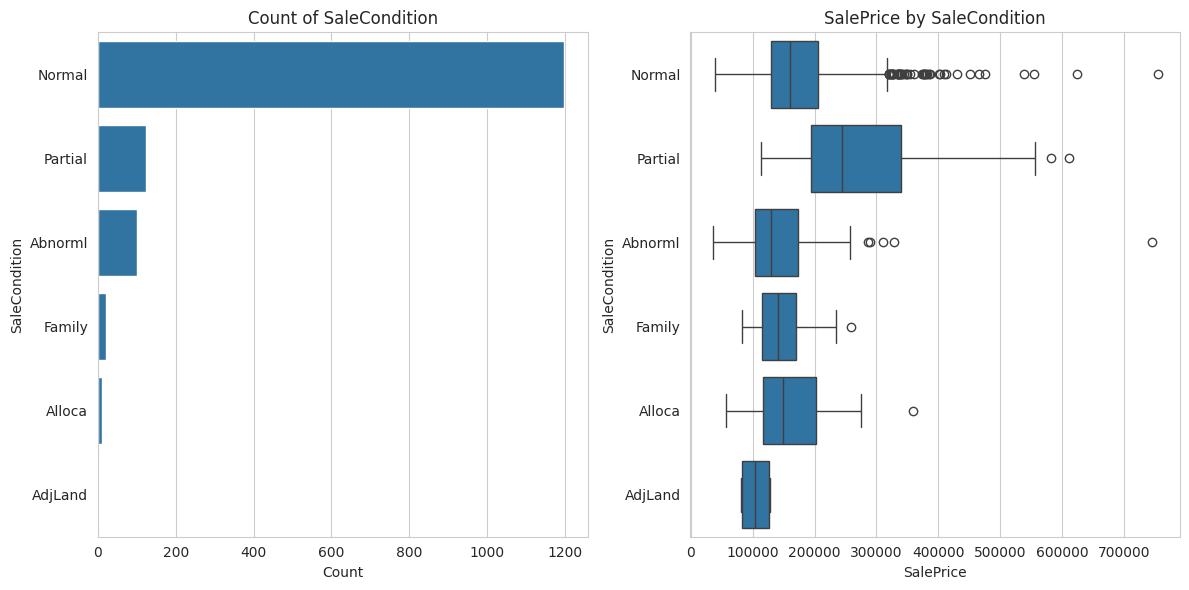

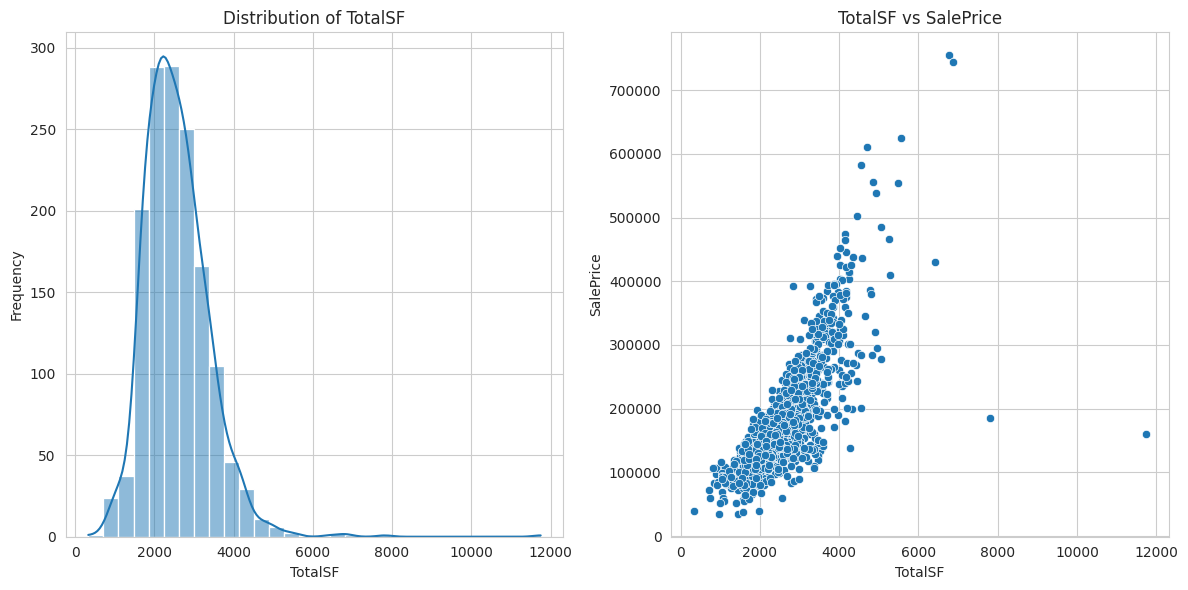

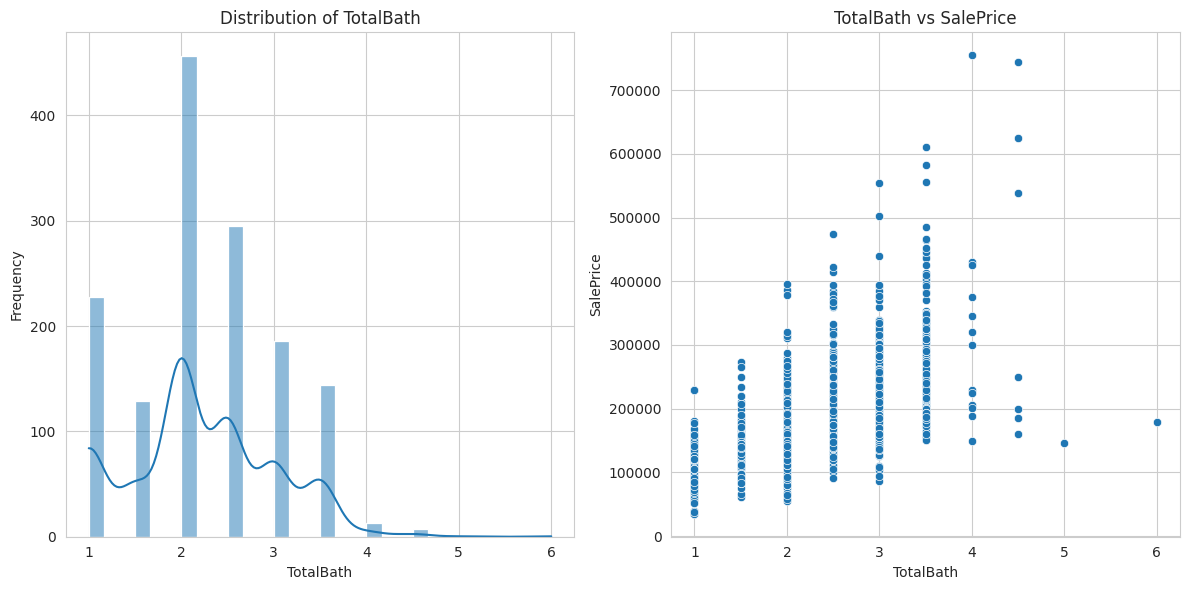

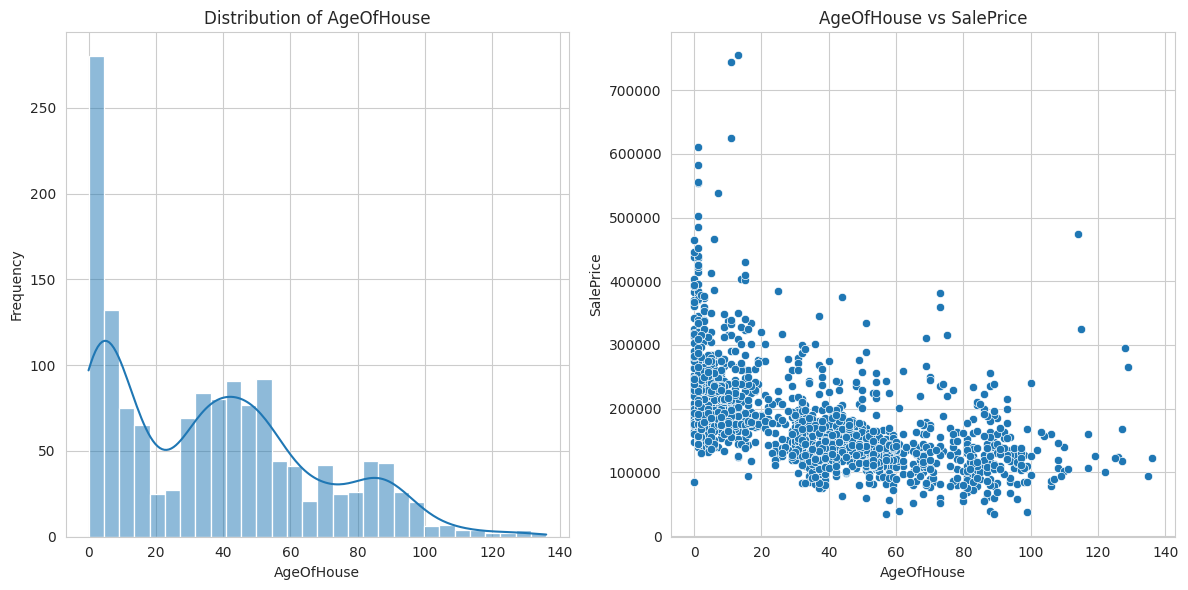

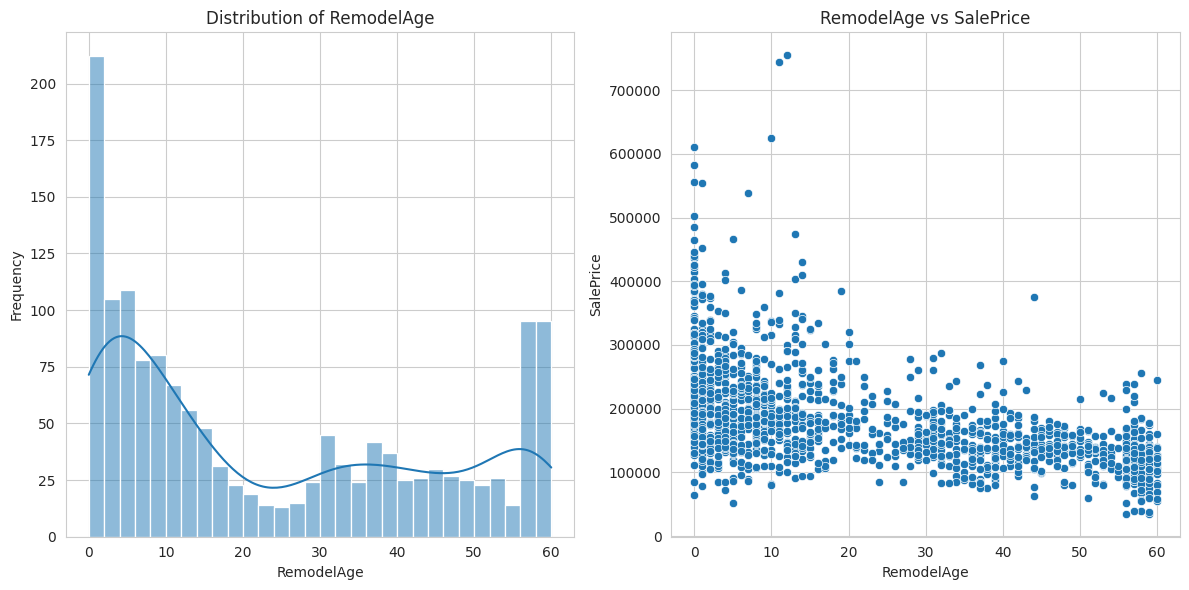

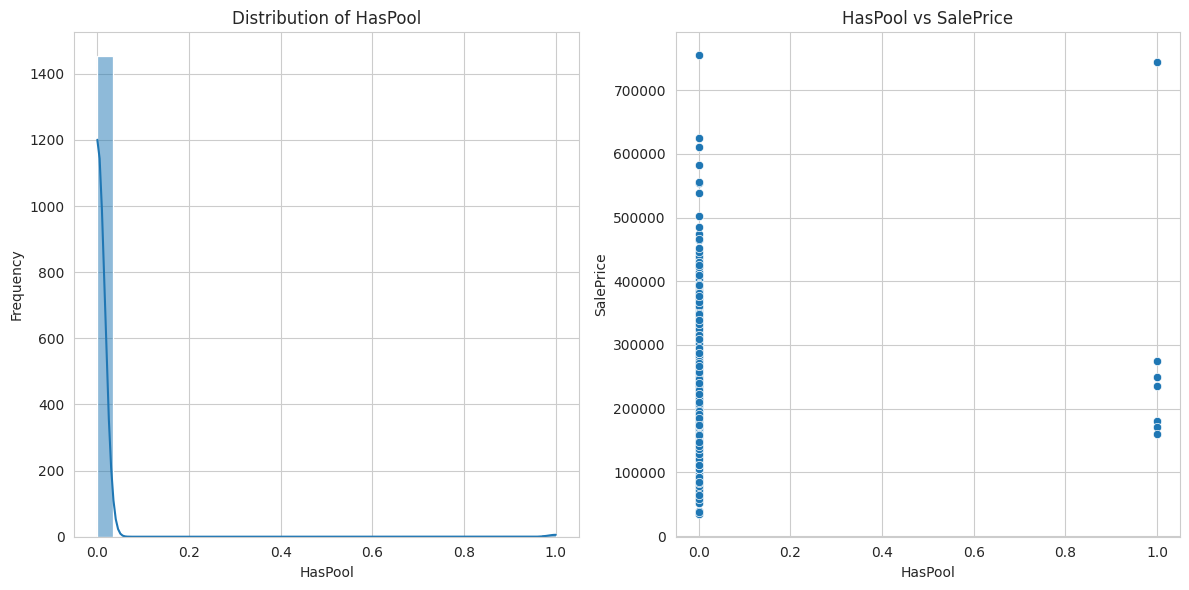

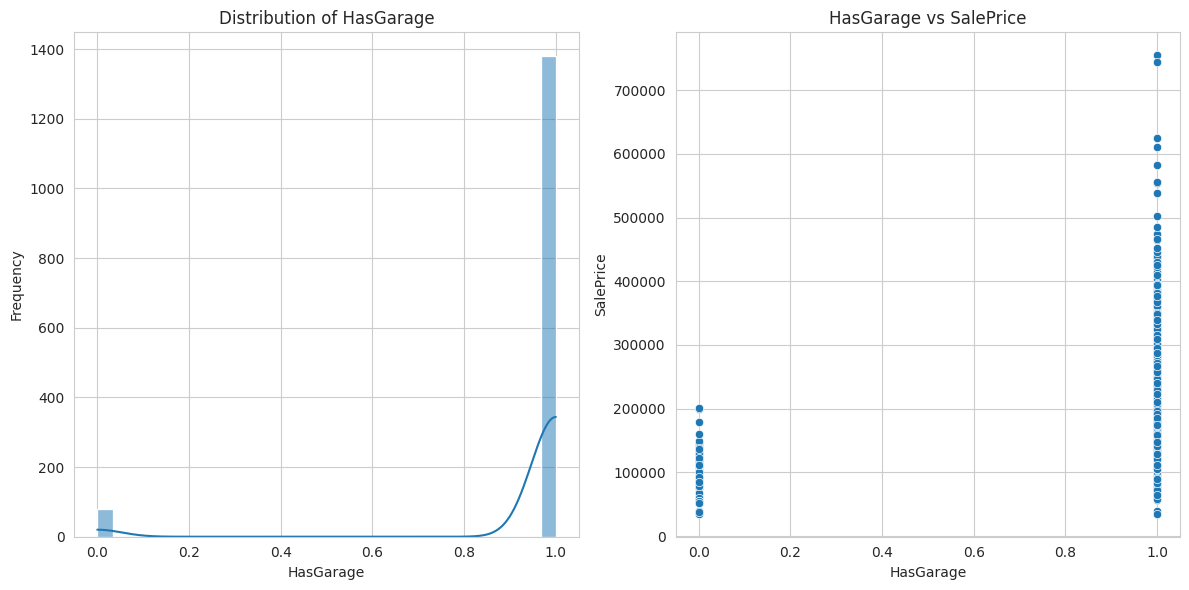

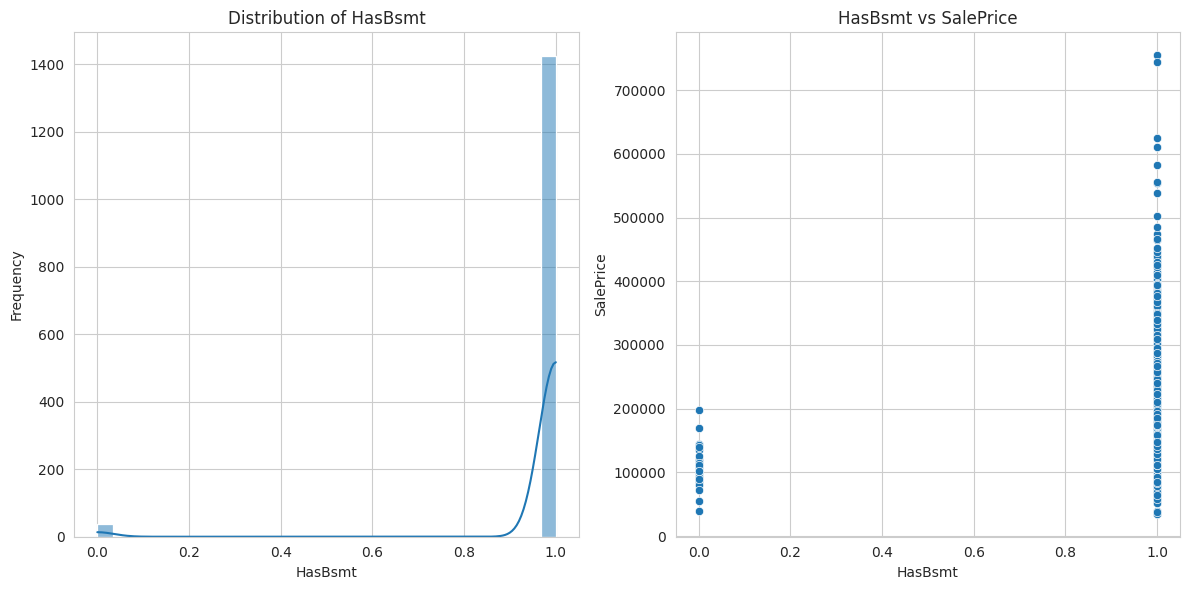

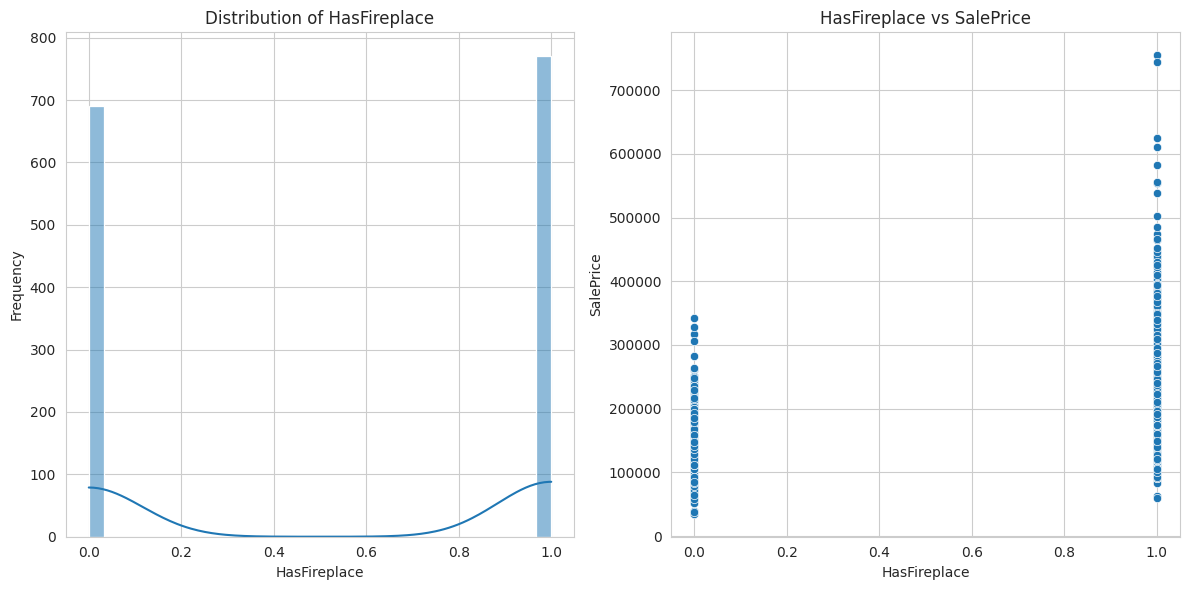

In [8]:
# Set style for plots
sns.set_style("whitegrid")

# Get list of features (excluding 'Id' and 'SalePrice' for individual plotting)
# Also exclude original columns that were combined into new features or are redundant for plotting
features_to_plot = [col for col in df.columns if col not in ['Id', 'SalePrice',
                                                             'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold',
                                                             'PoolArea', 'GarageArea', 'Fireplaces',
                                                             'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                                                             '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF',
                                                             '3SsnPorch', 'ScreenPorch', 'MiscVal', # These are often sparse and might not add much visual insight individually
                                                             'TotalBsmtSF' # Already used in TotalSF, HasBsmt
                                                             ]]

print("\nGenerating graphs for each feature...")

# Function to safely create plots, handling potential errors for specific columns
def create_plots(data, column, target):
    plt.figure(figsize=(12, 6))

    try:
        if data[column].dtype in ['int64', 'float64']: # Numerical feature
            # Distribution plot
            plt.subplot(1, 2, 1)
            sns.histplot(data[column], kde=True, bins=30)
            plt.title(f'Distribution of {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')

            # Scatter plot vs SalePrice
            plt.subplot(1, 2, 2)
            sns.scatterplot(x=data[column], y=data[target])
            plt.title(f'{column} vs {target}')
            plt.xlabel(column)
            plt.ylabel(target)

        else: # Categorical feature
            # Count plot
            plt.subplot(1, 2, 1)
            # Limit categories if too many for readability
            if data[column].nunique() > 20:
                top_categories = data[column].value_counts().nlargest(20).index
                sns.countplot(y=data[column], order=top_categories)
                plt.title(f'Count of {column} (Top 20)')
            else:
                sns.countplot(y=data[column], order=data[column].value_counts().index)
                plt.title(f'Count of {column}')
            plt.xlabel('Count')
            plt.ylabel(column)

            # Box plot vs SalePrice
            plt.subplot(1, 2, 2)
            if data[column].nunique() > 20:
                top_categories = data[column].value_counts().nlargest(20).index
                sns.boxplot(x=data[target], y=data[column], order=top_categories)
                plt.title(f'{target} by {column} (Top 20 Categories)')
            else:
                sns.boxplot(x=data[target], y=data[column], order=data[column].value_counts().index)
                plt.title(f'{target} by {column}')
            plt.xlabel(target)
            plt.ylabel(column)

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not generate plots for column {column} due to error: {e}")
        plt.close() # Close the figure to prevent display issues

for col in features_to_plot:
    create_plots(df, col, 'SalePrice')